# Importing Libraries and Downloading Data

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

#### Download data

In [2]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Dataset Preprocessing

In [3]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [4]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

#### Number of neurons in the input and output layers

In [5]:
input_nodes = num_features
output_nodes = num_classes

#### Class names

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Logging Sample Images

In [ ]:
# Store the index of first occurrence of each class
example_indices = [list(y_train).index(i) for i in range(num_classes)]

# example_images is a list containing one sample image per class, example_captions stores the corresponsing captions
example_images = []
example_captions = []
for index in example_indices:
    example_images.append(X_train.T[index].reshape((28, 28)))
    example_captions.append(class_names[y_train[index]])

# Log one sample image of each class to wandb
wandb.log({"Sample Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(example_images, example_captions)]})

# Components of the Neural Network Model

#### Activation functions and their derivatives

In [8]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [9]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    '''Function to initialise weights, biases and velocities/previous updates of the NN

    Parameters
    ----------
    layer_dims: list
        list of number of neurons per layer specifying layer dimensions in the format [#input_features,#hiddenunits...#hiddenunits,#outputclasses]

    init_mode: string
        initialisation mode, default-"xavier"

    Returns
    -------
    params: dict
        contains weights and biases. eg params[W1] is weight for layer 1

    previous updates: dict
        previous updates initialisation. This is used for different perposes for different optimisers.

    '''
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [10]:
def forward_propagate(X, params, activation_f):
    '''Function to forward propagate a minibatch of data once through the NN

    Parameters
    ----------
    X: numpy array
        data in (features,batch_size) format

    params: dict
        W and b of the NN

    activation_f: string
        activation function to be used except the output layer

    Returns
    -------
    output: numpy array
        contains the output probabilities for each class and each data sample after 1 pass
    A: numpy array
        contains all post-activations
    Z: numpy array
        contsins all pre-activations

    '''
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [11]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    '''Function to calculate gradients for a minibatch of data once through the NN through backpropagation

    Parameters
    ----------
    y_hat: numpy array
        output from forward propagation/ class probabilities

    y: numpy array
        actual class labels
     
    A: numpy array
        post-activations

    Z: numpy array
        pre-activations   

    params: dict
        contains W and b on the NN   

    activation_f: string
        activation function to be used except the output layer

    batch_size: int
        mini-batch-size

    loss: string
        loss function (MSE/Categorical crossentropy)

    lamb: float
        L2 regularisation lambda

    Returns
    -------
    gradients: dict
        gradients wrt weights and biases

    '''
    L = len(params)//2
    gradients = {}
    
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [12]:
def update_params_sgd(parameters,grads,learning_rate):
    ''' Update W and b of the NN according to sgd updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    Returns
    -------
    parameters: dict
        updated NN parameters

    '''
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    ''' Update W and b of the NN according to momentum updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    previous_updates: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        previous_updates[Wi] = beta*previous_updates[Wi] + (1-beta)*gradient[dWi]

    Returns
    -------
    parameters: dict
        updated NN parameters

    previous updates: dict
        updated previous updates 

    '''
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):
    ''' Update W and b of the NN according to RMSprop updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients square eg.
        v[Wi] = beta*v[Wi] + (1-beta)*(gradient[dWi]^2)

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated "velocities"

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    ''' Update W and b of the NN according to adam updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        v[Wi] = beta1*v[Wi] + (1-beta1)*(gradient[dWi])

    m: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients^2 eg.
        v[Wi] = beta2*v[Wi] + (1-beta2)*(gradient[dWi]^2)

    t: int
        timestep for Adam

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated previous updates

    m: dict
        updated "velocities"

    t: int
        updated timestep

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

######## Enter your new optimiser updates function here #############
#                                                                   #
#####################################################################

#### Function to plot the cost curves

In [13]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Prediction and Evaluation functions

In [14]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

# Hyperparameter tuning using Sweeps

In [15]:
def NN_fit():
    """
    This function is used for the hyperparameter tuning using wandb sweeps
    """
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }

    # Initialize a new wandb run
    wandb.init(project="DA6401-Assignment1", entity="anshul_2010-indian-institute-of-technology-madras", config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden)
    print(run_name)

    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN_predict(X_train, params, activation_f)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN_predict(X_val, params, activation_f)
        val_acc = accuracy_score(y_val, val_predictions)

        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": cost, "validation cost": val_cost, 'epoch': count})

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)


    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

    
    return params, epoch_cost

#### W&B Sweep

In this cell, we set up the configurations for the various hyperparameters and use the Sweeps feature to find the combination that gives us the highest validation accuracy. 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: fxobgot8
Sweep URL: https://wandb.ai/anshul_2010-indian-institute-of-technology-madras/DA6401-Assignment1/sweeps/fxobgot8


wandb: Agent Starting Run: k64lqql6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov
wandb: Currently logged in as: anshul_2010 (anshul_2010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


lr_0.0001_ac_sigmoid_in_random_uniform_op_nestorov_bs_256_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 4
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 6
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 8
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 10
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 12
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 14
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 16
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 18
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 20
Training cost:  2.302830650440628 	Validation cost: 2.3024770085326414
Epoch number : 22
Training cost: 

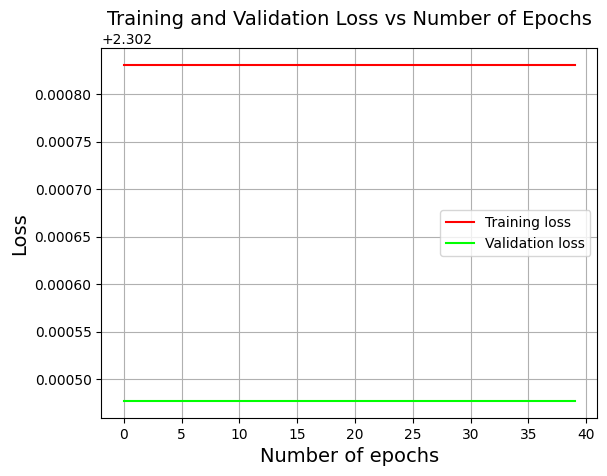

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 074pji1n with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_xavier_op_momentum_bs_128_L2_0.5_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  2.166972543578729 	Validation cost: 2.1768772489508863
Epoch number : 4
Training cost:  1.8207460148819283 	Validation cost: 1.8365753366250157
Epoch number : 6
Training cost:  1.3917358752893119 	Validation cost: 1.4081201643207772
Epoch number : 8
Training cost:  1.1220701924081606 	Validation cost: 1.1378130931645452
Epoch number : 10
Training cost:  0.9799372406571315 	Validation cost: 0.9956531879443605
Epoch number : 12
Training cost:  0.8931357592374369 	Validation cost: 0.9084185606697096
Epoch number : 14
Training cost:  0.8342217101419322 	Validation cost: 0.849320688807475
Epoch number : 16
Training cost:  0.7916142591048243 	Validation cost: 0.8066326854889486
Epoch number : 18
Training cost:  0.7585697420814221 	Validation cost: 0.7735978381663361
Epoch number : 20
Training cost:  0.7310678420480368 	Validation cost: 0.7460939193996342

Final training cost: 0.718417700003

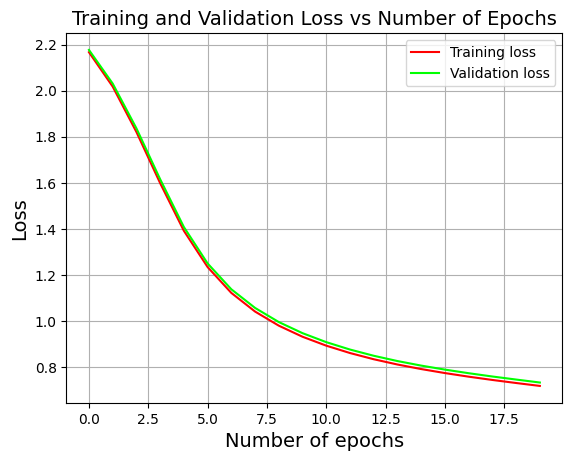

wandb: Agent Starting Run: x4pcsh36 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_normal_op_momentum_bs_64_L2_0.0005_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.3037803958473706 	Validation cost: 2.303861802553748
Epoch number : 4
Training cost:  2.302977634257102 	Validation cost: 2.3030819563913014
Epoch number : 6
Training cost:  2.3027092250568724 	Validation cost: 2.302829958349394
Epoch number : 8
Training cost:  2.302620475195892 	Validation cost: 2.3027518765687924
Epoch number : 10
Training cost:  2.3025913711031727 	Validation cost: 2.3027294060141257
Epoch number : 12
Training cost:  2.302581899531116 	Validation cost: 2.30272396676724
Epoch number : 14
Training cost:  2.3025788461749745 	Validation cost: 2.3027233344294724
Epoch number : 16
Training cost:  2.3025778762189018 	Validation cost: 2.3027238077569545
Epoch number : 18
Training cost:  2.3025775759901586 	Validation cost: 2.302724364215173
Epoch number : 20
Training cost:  2.302577487630932 	Validation cost: 2.3027247829230864
Epoch number : 22
Training co

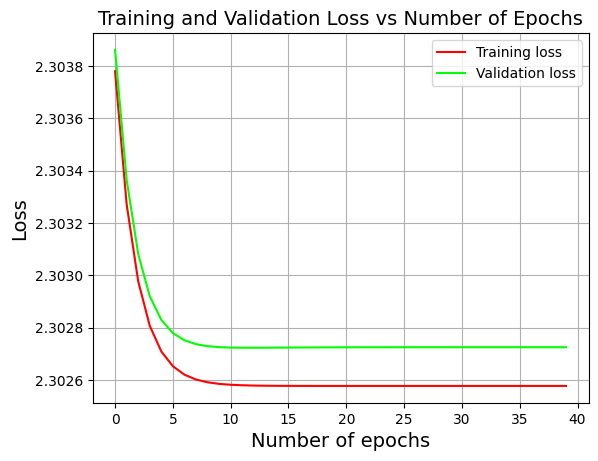

wandb: Agent Starting Run: u8lei7m6 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_random_normal_op_adam_bs_64_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.304957834621427 	Validation cost: 2.3041912337474146
Epoch number : 4
Training cost:  2.3030199297973684 	Validation cost: 2.3026502182954625
Epoch number : 6
Training cost:  2.3030036592923926 	Validation cost: 2.30264561564195
Epoch number : 8
Training cost:  2.303043695161526 	Validation cost: 2.302664435295505
Epoch number : 10
Training cost:  2.3030970680341905 	Validation cost: 2.3026895508172656
Epoch number : 12
Training cost:  2.303160194738309 	Validation cost: 2.3027184681804487
Epoch number : 14
Training cost:  2.303223491303248 	Validation cost: 2.302742918559273
Epoch number : 16
Training cost:  2.3031263908059114 	Validation cost: 2.3026027421921094
Epoch number : 18
Training cost:  2.263766992116865 	Validation cost: 2.2630238104710556
Epoch number : 20
Training cost:  1.3545407900430682 	Validation cost: 1.3519198503876368
Epoch number : 22
Training cost:  0

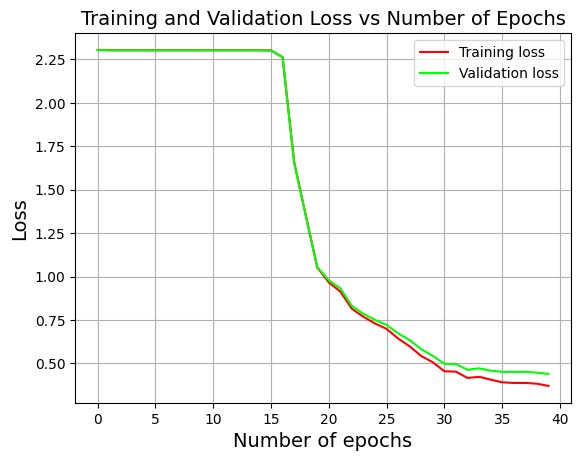

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h1babz04 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_xavier_op_nestorov_bs_512_L2_0.5_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  2.33540348326888 	Validation cost: 2.3395128474231357
Epoch number : 4
Training cost:  2.33540348326888 	Validation cost: 2.3395128474231357
Epoch number : 6
Training cost:  2.33540348326888 	Validation cost: 2.3395128474231357
Epoch number : 8
Training cost:  2.33540348326888 	Validation cost: 2.3395128474231357
Epoch number : 10
Training cost:  2.33540348326888 	Validation cost: 2.3395128474231357

Final training cost: 2.33540348326888


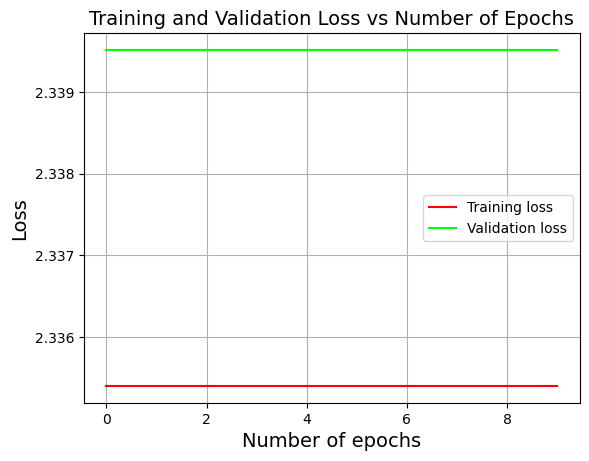

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h8yos5uv with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_xavier_op_sgd_bs_64_L2_0.0005_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  2.136699614461298 	Validation cost: 2.142817220601999
Epoch number : 4
Training cost:  1.8257842671880988 	Validation cost: 1.8339873612903512
Epoch number : 6
Training cost:  1.6035638615968235 	Validation cost: 1.6141552145501574
Epoch number : 8
Training cost:  1.4379061799123973 	Validation cost: 1.4498426015487185
Epoch number : 10
Training cost:  1.3122666669409835 	Validation cost: 1.324853683853991

Final training cost: 1.2606316993480893


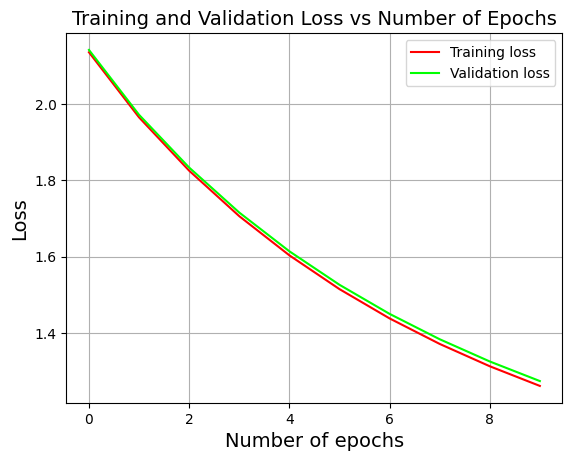

wandb: Agent Starting Run: m7p2fllz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_xavier_op_nadam_bs_512_L2_0.5_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  0.7491059105253445 	Validation cost: 0.768750786640832
Epoch number : 4
Training cost:  0.5041361778056074 	Validation cost: 0.5160670487961662
Epoch number : 6
Training cost:  0.48812408222600046 	Validation cost: 0.5031476475083188
Epoch number : 8
Training cost:  0.46839589368010737 	Validation cost: 0.4877055653475809
Epoch number : 10
Training cost:  0.4338139376600546 	Validation cost: 0.45297566565905767

Final training cost: 0.4393297403601509


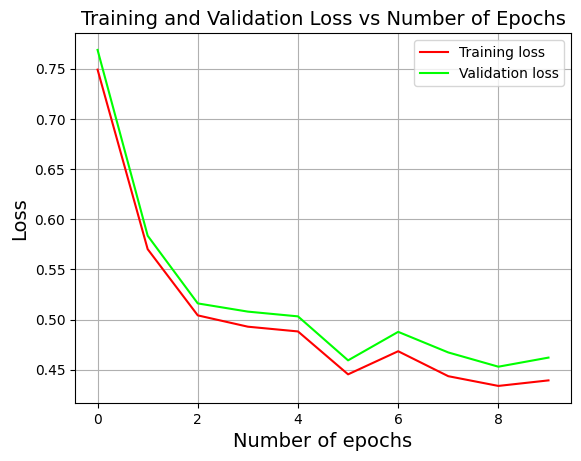

wandb: Agent Starting Run: g5vijc04 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_uniform_op_adam_bs_256_L2_0.5_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  1.9291957726612305 	Validation cost: 1.9209503185673042
Epoch number : 4
Training cost:  1.6536910431862006 	Validation cost: 1.64642783916355
Epoch number : 6
Training cost:  1.553080332079671 	Validation cost: 1.5473125751967371
Epoch number : 8
Training cost:  1.5353651449092254 	Validation cost: 1.5399028036756368
Epoch number : 10
Training cost:  1.5018910769374338 	Validation cost: 1.5071578107842372
Epoch number : 12
Training cost:  1.4418493317116094 	Validation cost: 1.446056278519659
Epoch number : 14
Training cost:  1.386904113597567 	Validation cost: 1.3943158002648006
Epoch number : 16
Training cost:  1.3231711412785365 	Validation cost: 1.3405640997409034
Epoch number : 18
Training cost:  1.015244406877844 	Validation cost: 1.0187309841417227
Epoch number : 20
Training cost:  0.7804296667211924 	Validation cost: 0.7909538812393655

Final training cost: 0.838110895685

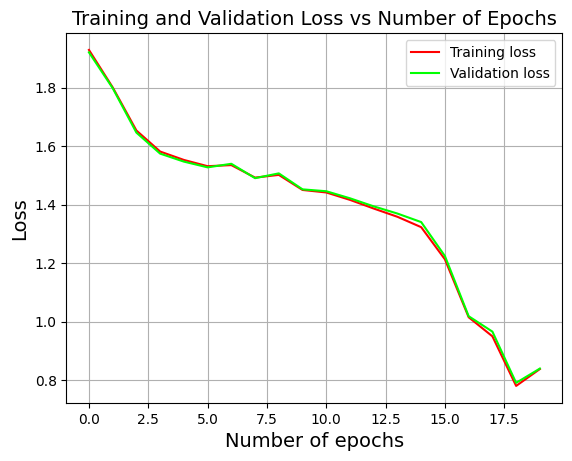

wandb: Agent Starting Run: bwx4zcwp with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_xavier_op_RMSprop_bs_512_L2_0_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.531885379441955 	Validation cost: 0.5388791621111112
Epoch number : 4
Training cost:  0.41319126757075436 	Validation cost: 0.4246521618340547
Epoch number : 6
Training cost:  0.38139348256399386 	Validation cost: 0.3994398650249985
Epoch number : 8
Training cost:  0.3453202172975437 	Validation cost: 0.36951378081827313
Epoch number : 10
Training cost:  0.32913675549010657 	Validation cost: 0.35988373008179453
Epoch number : 12
Training cost:  0.3283519297914765 	Validation cost: 0.36668265302335906
Epoch number : 14
Training cost:  0.3182037128856138 	Validation cost: 0.3628500176355338
Epoch number : 16
Training cost:  0.30443920535604735 	Validation cost: 0.355477933757641
Epoch number : 18
Training cost:  0.30161868525420554 	Validation cost: 0.3599214967604185
Epoch number : 20
Training cost:  0.2944353776262328 	Validation cost: 0.35942083730271507
Epoch number : 22
Training cos

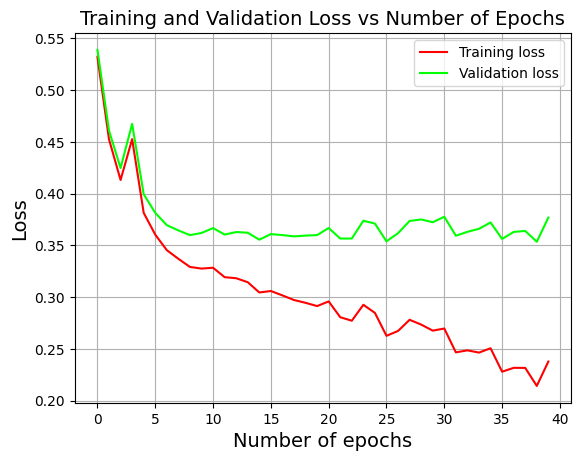

wandb: Agent Starting Run: gk8lv4zi with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_random_uniform_op_nestorov_bs_32_L2_0.5_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 4
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 6
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 8
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 10
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 12
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 14
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 16
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 18
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 20
Training cost:  2.302689914063644 	Validation cost: 2.302772657127864
Epoch number : 22
Training cost:  2.30268991406

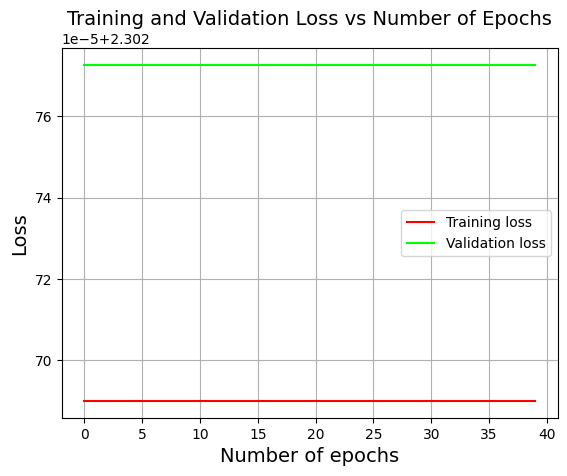

wandb: Agent Starting Run: ne35gym5 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_xavier_op_nadam_bs_16_L2_0.0005_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.8701206344873049 	Validation cost: 0.8775357427001753
Epoch number : 4
Training cost:  0.5442066889587343 	Validation cost: 0.5482772034403802
Epoch number : 6
Training cost:  0.4580401323338073 	Validation cost: 0.46155142159267054
Epoch number : 8
Training cost:  0.41908041767965504 	Validation cost: 0.4262187993125315
Epoch number : 10
Training cost:  0.3952266710775315 	Validation cost: 0.40615172628646506

Final training cost: 0.3858758459433367


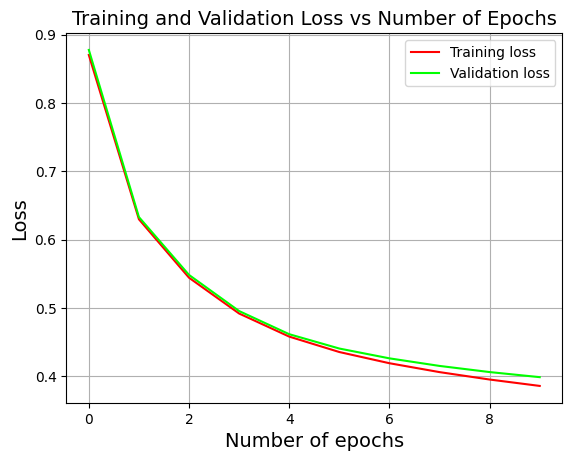

wandb: Agent Starting Run: co8by0bd with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_random_uniform_op_momentum_bs_64_L2_0_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  2.3025834191993133 	Validation cost: 2.302584264821002
Epoch number : 4
Training cost:  2.3025830241808625 	Validation cost: 2.302586506861315
Epoch number : 6
Training cost:  2.302582637818471 	Validation cost: 2.3025887133474474
Epoch number : 8
Training cost:  2.302582259822373 	Validation cost: 2.302590884727509
Epoch number : 10
Training cost:  2.302581889912347 	Validation cost: 2.302593021446921

Final training cost: 2.302581707904575


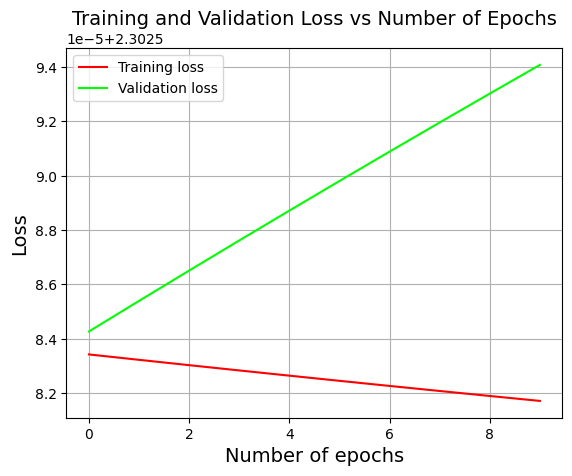

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y5e2t9vq with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_64_L2_0_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  2.3712323580295642 	Validation cost: 2.3746639396662266
Epoch number : 4
Training cost:  2.3325300585967153 	Validation cost: 2.335357223151967
Epoch number : 6
Training cost:  2.3162456977520787 	Validation cost: 2.3184372663468107
Epoch number : 8
Training cost:  2.308754968454544 	Validation cost: 2.3104136175645125
Epoch number : 10
Training cost:  2.3051731240587565 	Validation cost: 2.3064188546347664
Epoch number : 12
Training cost:  2.3034298505609825 	Validation cost: 2.3043675472836487
Epoch number : 14
Training cost:  2.3025733069074086 	Validation cost: 2.3032860644584217
Epoch number : 16
Training cost:  2.3021488924266413 	Validation cost: 2.302699528558288
Epoch number : 18
Training cost:  2.3019358280456284 	Validation cost: 2.3023706019814525
Epoch number : 20
Training cost:  2.3018261892172864 	Validation cost: 2.302178624859539

Final training cost: 2.3017923755646

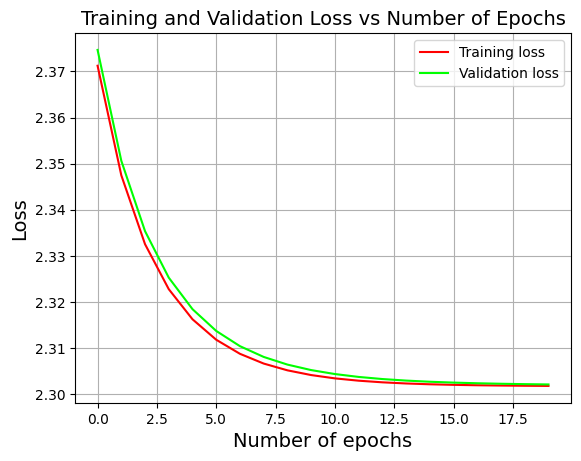

wandb: Agent Starting Run: tlswofo1 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_normal_op_RMSprop_bs_256_L2_0.0005_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302583143982308 	Validation cost: 2.3026045866448728
Epoch number : 4
Training cost:  2.3025806785672325 	Validation cost: 2.302634878011269
Epoch number : 6
Training cost:  2.302579223589278 	Validation cost: 2.3026596540565434

Final training cost: 2.302579223589278


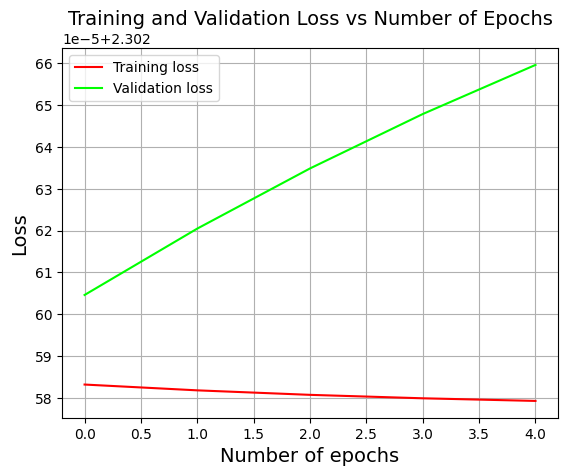

wandb: Agent Starting Run: e1bxgb6x with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_normal_op_sgd_bs_32_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  2.3025832934994424 	Validation cost: 2.3025860981993973
Epoch number : 4
Training cost:  2.3025823393661398 	Validation cost: 2.3025902826007107
Epoch number : 6
Training cost:  2.3025815771458387 	Validation cost: 2.3025945128090144
Epoch number : 8
Training cost:  2.3025809444984446 	Validation cost: 2.3025986964596403
Epoch number : 10
Training cost:  2.3025804598163035 	Validation cost: 2.302602859663526
Epoch number : 12
Training cost:  2.3025800105096415 	Validation cost: 2.302606902921646
Epoch number : 14
Training cost:  2.3025795881824633 	Validation cost: 2.302610822463397
Epoch number : 16
Training cost:  2.3025791902566715 	Validation cost: 2.3026146218925923
Epoch number : 18
Training cost:  2.302578815036696 	Validation cost: 2.3026183030613163
Epoch number : 20
Training cost:  2.302578460915872 	Validation cost: 2.3026218701532732

Final training cost: 2.30257829117221

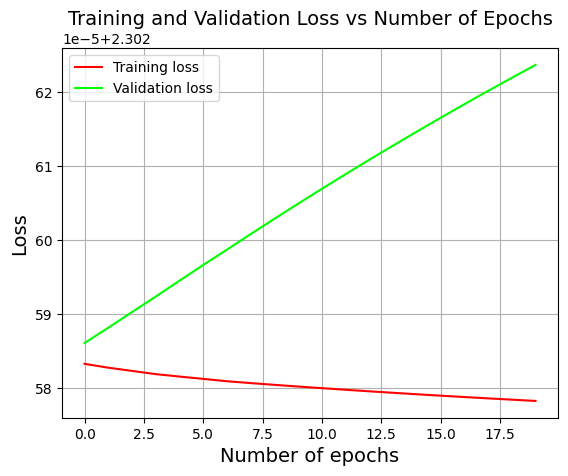

wandb: Agent Starting Run: wjsi6ofp with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_xavier_op_RMSprop_bs_16_L2_0.0005_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  0.5328410694959324 	Validation cost: 0.5406486897580064
Epoch number : 4
Training cost:  0.4037616574744662 	Validation cost: 0.417042887010716
Epoch number : 6
Training cost:  0.3687272275351915 	Validation cost: 0.3872727428871089
Epoch number : 8
Training cost:  0.35031221127185 	Validation cost: 0.3739741866012437
Epoch number : 10
Training cost:  0.33871226038204844 	Validation cost: 0.36740868432043194
Epoch number : 12
Training cost:  0.33009941781344115 	Validation cost: 0.36400308071846316
Epoch number : 14
Training cost:  0.3224891875485471 	Validation cost: 0.36159678919991073
Epoch number : 16
Training cost:  0.31497166211734495 	Validation cost: 0.358989213863421
Epoch number : 18
Training cost:  0.30748822221512667 	Validation cost: 0.3561675280314315
Epoch number : 20
Training cost:  0.30038654386361524 	Validation cost: 0.3535909206241686

Final training cost: 0.2970

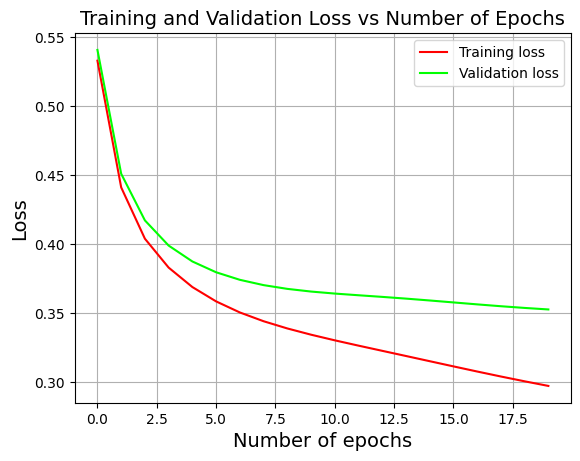

wandb: Agent Starting Run: 8m2nagzj with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_uniform_op_RMSprop_bs_64_L2_0.0005_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  1.8784744611330408 	Validation cost: 1.865996544195473
Epoch number : 4
Training cost:  nan 	Validation cost: nan
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan
Epoch number : 12
Training cost:  nan 	Validation cost: nan
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan

Final training cost: nan


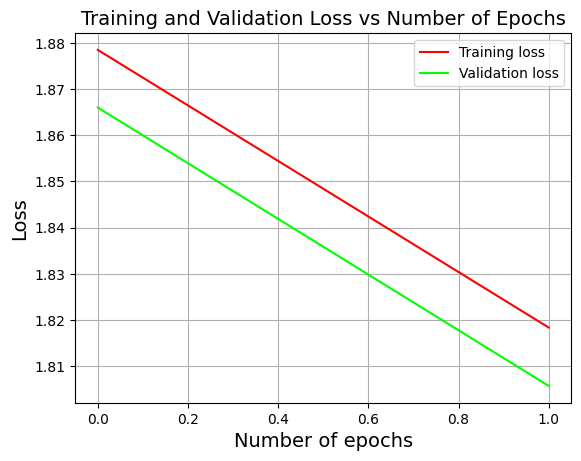

wandb: Agent Starting Run: 8cd7o8fr with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_xavier_op_nadam_bs_16_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  0.9031125815906459 	Validation cost: 0.9169619300678756
Epoch number : 4
Training cost:  0.9244375334113396 	Validation cost: 0.9408305095113256
Epoch number : 6
Training cost:  0.9179622692580295 	Validation cost: 0.9362519381948383
Epoch number : 8
Training cost:  0.981681613490617 	Validation cost: 0.9949977792867566
Epoch number : 10
Training cost:  0.9342365795800534 	Validation cost: 0.9471081515145482

Final training cost: 0.9410868871730584


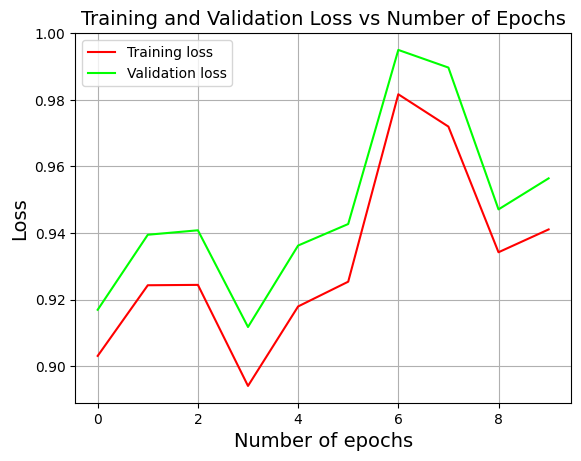

wandb: Agent Starting Run: fdov38lr with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_random_uniform_op_nestorov_bs_32_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 4
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 6
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 8
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 10
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 12
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 14
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 16
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 18
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 20
Training cost:  2.3026802002275075 	Validation cost: 2.302685232602637
Epoch number : 22
Training cost:  

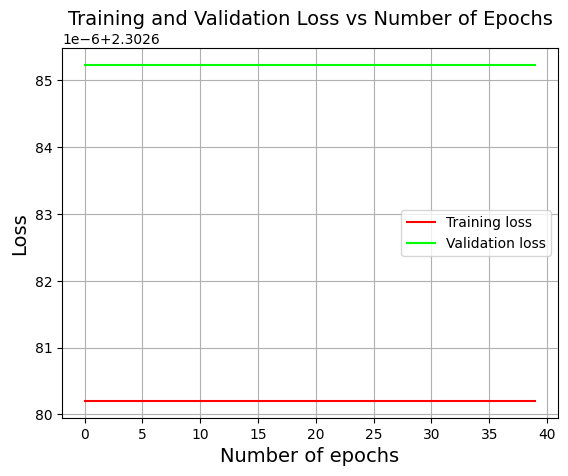

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2q4zx2y5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_64_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3042326792917907 	Validation cost: 2.303833320685151
Epoch number : 4
Training cost:  2.303552423470461 	Validation cost: 2.3030647337562478
Epoch number : 6
Training cost:  2.3030465116541174 	Validation cost: 2.3025944043856654
Epoch number : 8
Training cost:  2.3028169362486306 	Validation cost: 2.3024698783884445
Epoch number : 10
Training cost:  2.302714556536685 	Validation cost: 2.3024651939822176

Final training cost: 2.3026844717999975


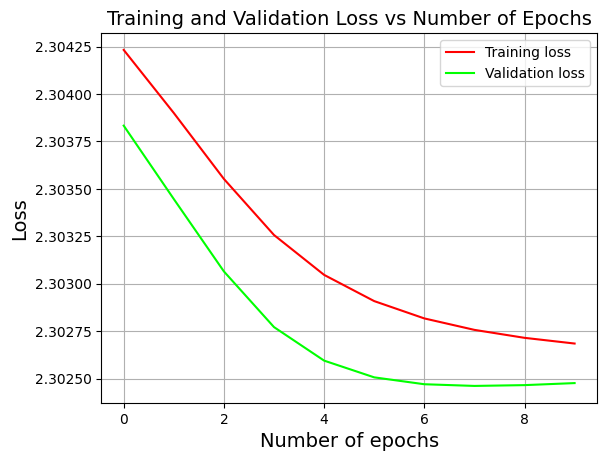

wandb: Agent Starting Run: zgqidyl5 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_32_L2_0.0005_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  1.5438184075127712 	Validation cost: 1.5520500008416793
Epoch number : 4
Training cost:  0.7603801276396507 	Validation cost: 0.7627189643645146
Epoch number : 6
Training cost:  0.5358338214424092 	Validation cost: 0.5549031645923208
Epoch number : 8
Training cost:  0.41509771252696015 	Validation cost: 0.4548003958280149
Epoch number : 10
Training cost:  0.36812063077752893 	Validation cost: 0.41699483027996653
Epoch number : 12
Training cost:  0.3413677855327933 	Validation cost: 0.39779808933651956
Epoch number : 14
Training cost:  0.31463127282183734 	Validation cost: 0.3796700426986322
Epoch number : 16
Training cost:  0.29789540388026053 	Validation cost: 0.37238739533647147
Epoch number : 18
Training cost:  0.2828267358389868 	Validation cost: 0.3657024479561834
Epoch number : 20
Training cost:  0.26810417457549046 	Validation cost: 0.35706574094375526
Epoch number 

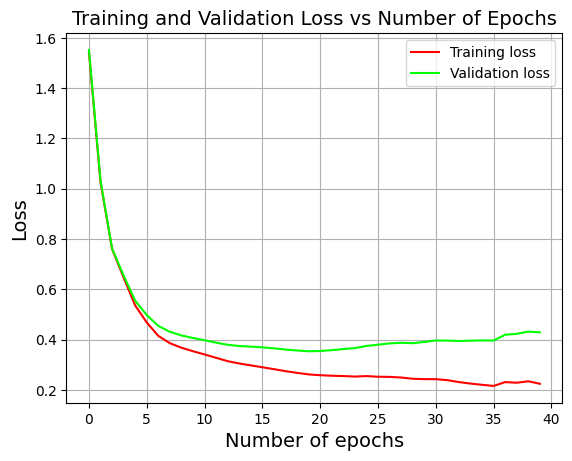

wandb: Agent Starting Run: 03x9rmjv with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_relu_in_random_uniform_op_nadam_bs_32_L2_0.0005_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  0.994712652911656 	Validation cost: 0.9966891131358002
Epoch number : 4
Training cost:  1.0367704730192344 	Validation cost: 1.0871376551598524
Epoch number : 6
Training cost:  0.9665412546731347 	Validation cost: 1.0321410452857867
Epoch number : 8
Training cost:  0.8314457957014112 	Validation cost: 0.8835945488844171
Epoch number : 10
Training cost:  nan 	Validation cost: nan

Final training cost: nan


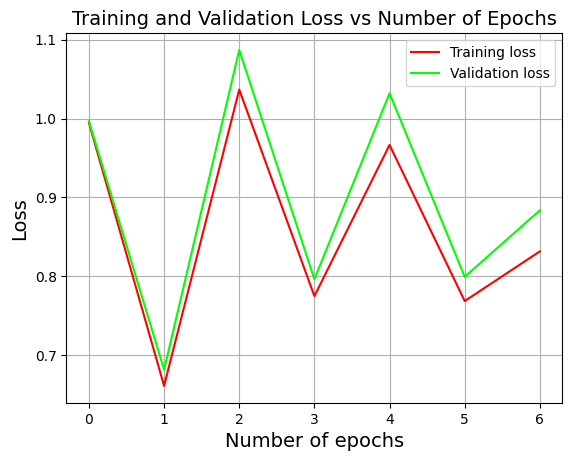

wandb: Agent Starting Run: 6aqk5btj with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_random_uniform_op_nadam_bs_64_L2_0.0005_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  1.338890796555835 	Validation cost: 1.3490418183585184
Epoch number : 4
Training cost:  0.5641793118926952 	Validation cost: 0.5652399821913356
Epoch number : 6
Training cost:  0.43299891078124236 	Validation cost: 0.4489122089607412
Epoch number : 8
Training cost:  0.3904534504790898 	Validation cost: 0.4176746495754241
Epoch number : 10
Training cost:  0.3621278302281188 	Validation cost: 0.40448019734487856
Epoch number : 12
Training cost:  0.3502912082141836 	Validation cost: 0.39434294568612666
Epoch number : 14
Training cost:  0.3465069244335566 	Validation cost: 0.39848790390789335
Epoch number : 16
Training cost:  0.32078285835491294 	Validation cost: 0.3859222504976098
Epoch number : 18
Training cost:  0.3190101518028417 	Validation cost: 0.3918903086046769
Epoch number : 20
Training cost:  0.3131356857601537 	Validation cost: 0.3939284829663934

Final training cost: 0

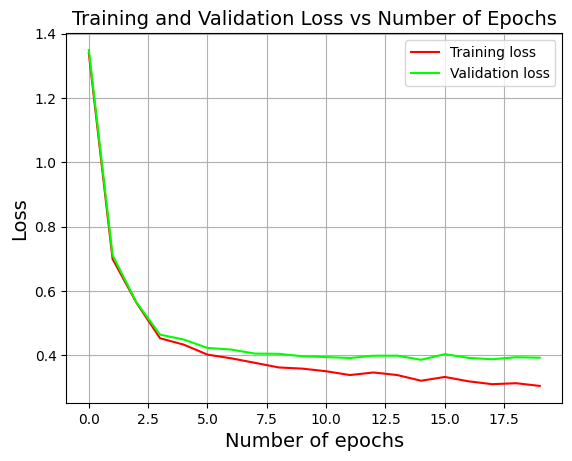

wandb: Agent Starting Run: l3d76768 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_random_uniform_op_nadam_bs_256_L2_0.0005_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.289688405079597 	Validation cost: 2.2886364649405317
Epoch number : 4
Training cost:  1.689015705181012 	Validation cost: 1.6922285655852574
Epoch number : 6
Training cost:  1.6571362393523508 	Validation cost: 1.662260827769129
Epoch number : 8
Training cost:  1.606347793222423 	Validation cost: 1.6120638457986385
Epoch number : 10
Training cost:  1.2119666932727768 	Validation cost: 1.217591642554451

Final training cost: 1.108315823827169


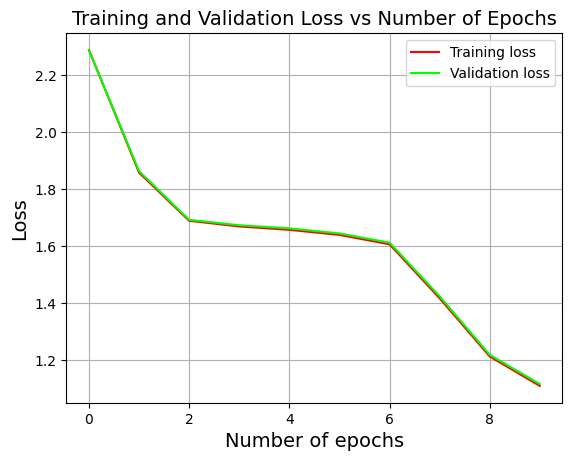

wandb: Agent Starting Run: w2v39w7b with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_xavier_op_momentum_bs_32_L2_0_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  2.2394514077988763 	Validation cost: 2.244604268543048
Epoch number : 4
Training cost:  2.083035511808721 	Validation cost: 2.087556808191017
Epoch number : 6
Training cost:  1.8604171471977746 	Validation cost: 1.8659339674229722
Epoch number : 8
Training cost:  1.5847931408375722 	Validation cost: 1.5928310366195362
Epoch number : 10
Training cost:  1.3367257408541333 	Validation cost: 1.3481207287390498
Epoch number : 12
Training cost:  1.146363105989239 	Validation cost: 1.1597737647288489
Epoch number : 14
Training cost:  1.0142927614904789 	Validation cost: 1.0282725761808105
Epoch number : 16
Training cost:  0.9269788214964847 	Validation cost: 0.9411031184102606
Epoch number : 18
Training cost:  0.8662609118243005 	Validation cost: 0.880210117629952
Epoch number : 20
Training cost:  0.8210906977967168 	Validation cost: 0.8348034464257819
Epoch number : 22
Training cost:  0.7857

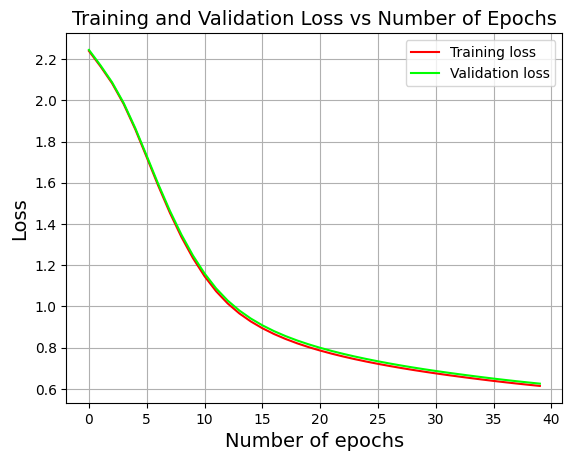

wandb: Agent Starting Run: csnkwx9r with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_512_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  2.3025744001346506 	Validation cost: 2.3030681431629954
Epoch number : 4
Training cost:  2.3024725055005932 	Validation cost: 2.302976774492386
Epoch number : 6
Training cost:  2.302195142340601 	Validation cost: 2.3027163681722476
Epoch number : 8
Training cost:  2.2998147160988496 	Validation cost: 2.3003518174424773
Epoch number : 10
Training cost:  1.7578633110122326 	Validation cost: 1.7623271047138045
Epoch number : 12
Training cost:  1.1038989632765417 	Validation cost: 1.110208639258309
Epoch number : 14
Training cost:  1.0055321018390653 	Validation cost: 1.015653262749724
Epoch number : 16
Training cost:  0.9687506271184689 	Validation cost: 0.9793557593908578
Epoch number : 18
Training cost:  0.9459077409641756 	Validation cost: 0.9568332790021551
Epoch number : 20
Training cost:  0.9255551864011822 	Validation cost: 0.937266336232439
Epoch number : 22
Training cost: 

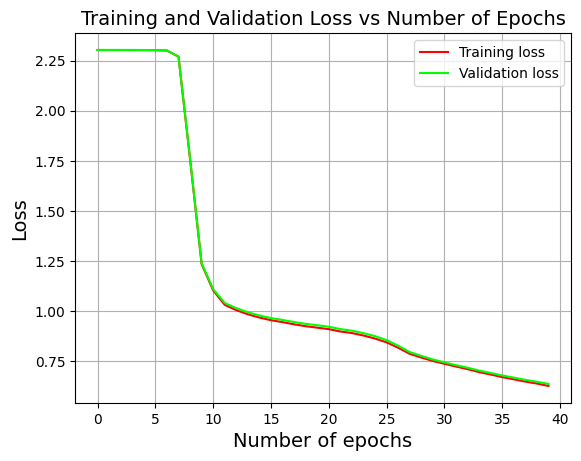

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fpfzu4be with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_64_L2_0.0005_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.45702771198845826 	Validation cost: 0.46229938083392763
Epoch number : 4
Training cost:  0.3788444005947581 	Validation cost: 0.3921388693336758
Epoch number : 6
Training cost:  0.3437648415916439 	Validation cost: 0.3648922636164221

Final training cost: 0.3437648415916439


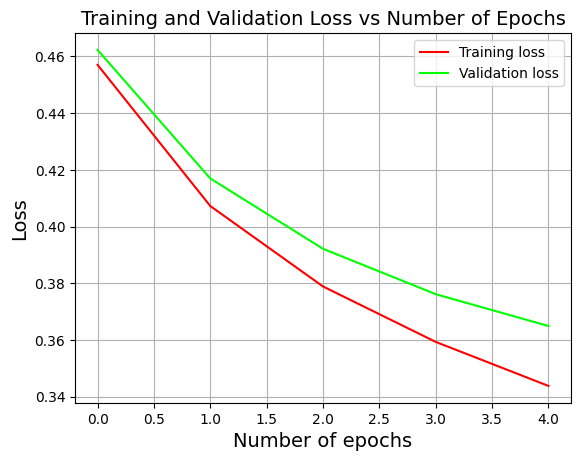

wandb: Agent Starting Run: x51klud4 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_xavier_op_adam_bs_64_L2_0.5_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.6826545223030521 	Validation cost: 0.6941973988077433
Epoch number : 4
Training cost:  0.591374147889387 	Validation cost: 0.6021749506677166
Epoch number : 6
Training cost:  0.55319015088896 	Validation cost: 0.5612266313625937
Epoch number : 8
Training cost:  0.5440531510033093 	Validation cost: 0.5529883073516374
Epoch number : 10
Training cost:  0.5492868890834175 	Validation cost: 0.5580767169462114

Final training cost: 0.5667341665950186


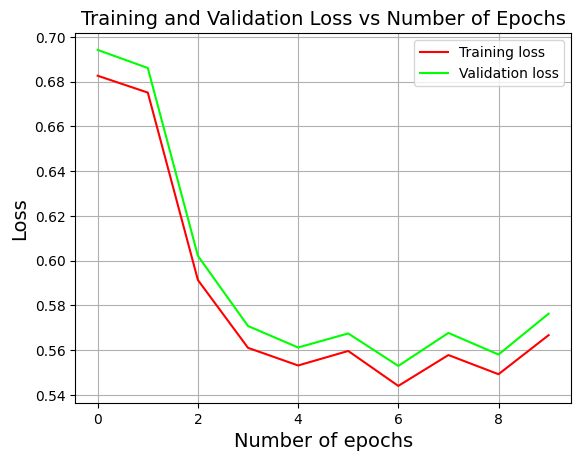

wandb: Agent Starting Run: bhuz1z6v with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_random_normal_op_nadam_bs_32_L2_0.0005_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.7088021175653338 	Validation cost: 0.723582707049627
Epoch number : 4
Training cost:  0.5383762636453083 	Validation cost: 0.5619594782195951
Epoch number : 6
Training cost:  0.46007948105489804 	Validation cost: 0.4977047010432292
Epoch number : 8
Training cost:  0.4072181418943798 	Validation cost: 0.4467905994148451
Epoch number : 10
Training cost:  0.36393122649473403 	Validation cost: 0.42364165076513366
Epoch number : 12
Training cost:  0.34976068697323615 	Validation cost: 0.40774469324615625
Epoch number : 14
Training cost:  0.38323178304199995 	Validation cost: 0.4592324842987563
Epoch number : 16
Training cost:  0.3340490968438585 	Validation cost: 0.4083790146600212
Epoch number : 18
Training cost:  0.3478265336875137 	Validation cost: 0.4306609158806955
Epoch number : 20
Training cost:  0.34840139473652193 	Validation cost: 0.431009406881385
Epoch number : 22
Trai

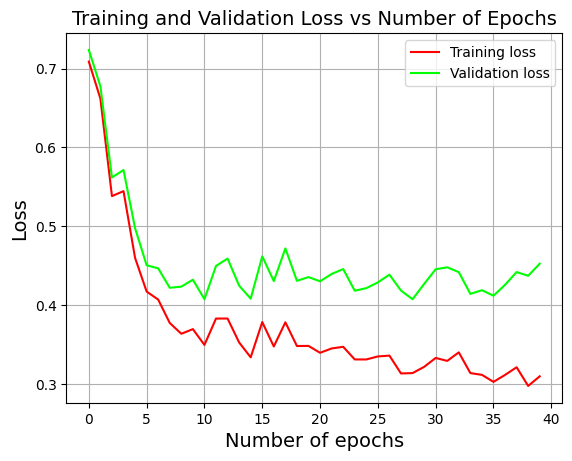

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nr714189 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_uniform_op_momentum_bs_512_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3026566057062667 	Validation cost: 2.302596938075893
Epoch number : 4
Training cost:  2.3026511627721353 	Validation cost: 2.3026038545894543
Epoch number : 6
Training cost:  2.3026461542573946 	Validation cost: 2.3026106963462913
Epoch number : 8
Training cost:  2.302641545392207 	Validation cost: 2.302617449346911
Epoch number : 10
Training cost:  2.3026373041848482 	Validation cost: 2.3026241015371447

Final training cost: 2.302635312160528


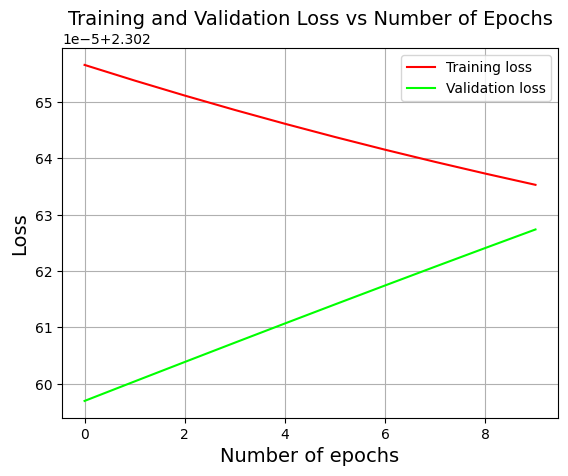

wandb: Agent Starting Run: hl622982 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_xavier_op_momentum_bs_128_L2_0.5_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  1.9206278525751477 	Validation cost: 1.9348331506063243
Epoch number : 4
Training cost:  1.5042175722943538 	Validation cost: 1.5205342514358384
Epoch number : 6
Training cost:  1.2673810497808162 	Validation cost: 1.284240548150127
Epoch number : 8
Training cost:  1.1041749844743043 	Validation cost: 1.1218647683903262
Epoch number : 10
Training cost:  0.9873241534783419 	Validation cost: 1.005715382855657
Epoch number : 12
Training cost:  0.903598231334585 	Validation cost: 0.9225160917722737
Epoch number : 14
Training cost:  0.8424526643239563 	Validation cost: 0.8617575385563595
Epoch number : 16
Training cost:  0.7961846395739374 	Validation cost: 0.8157382344529392
Epoch number : 18
Training cost:  0.7598256935197857 	Validation cost: 0.7794897210105973
Epoch number : 20
Training cost:  0.7302751920153557 	Validation cost: 0.7499269371203758
Epoch number : 22
Training cost:  0.7

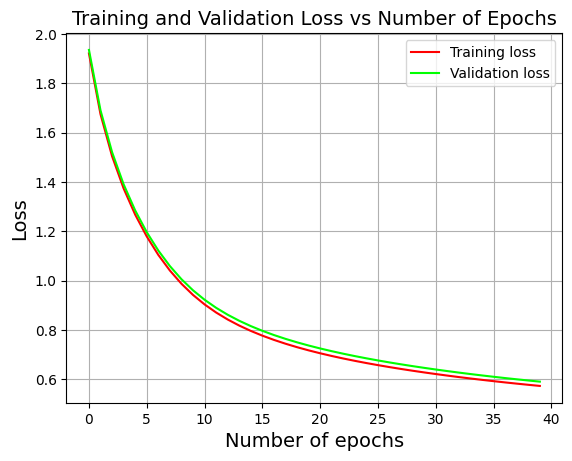

wandb: Agent Starting Run: 39r15452 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_uniform_op_RMSprop_bs_16_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3025811311434916 	Validation cost: 2.3026283149904128
Epoch number : 4
Training cost:  2.302578650217121 	Validation cost: 2.302671548353098
Epoch number : 6
Training cost:  2.3025780134934646 	Validation cost: 2.3026902881118176
Epoch number : 8
Training cost:  2.3025778182658736 	Validation cost: 2.3026983027783183
Epoch number : 10
Training cost:  2.302577748947359 	Validation cost: 2.3027017116001343

Final training cost: 2.3025777324448744


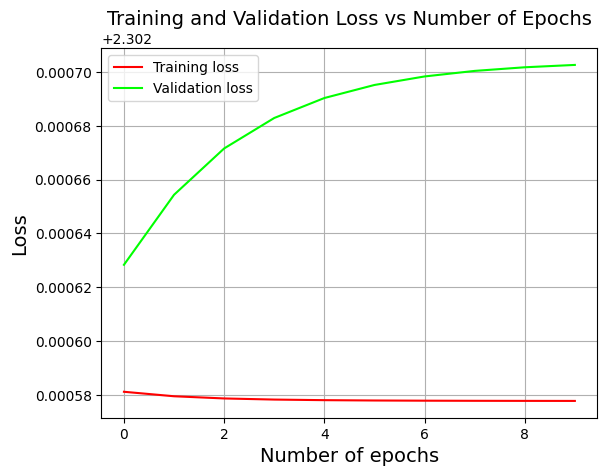

wandb: Agent Starting Run: cg9hweh2 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_random_uniform_op_RMSprop_bs_512_L2_0.0005_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  2.302584517210861 	Validation cost: 2.3026797970467623
Epoch number : 4
Training cost:  2.302582390048797 	Validation cost: 2.302687268166666
Epoch number : 6
Training cost:  2.302581349538379 	Validation cost: 2.3026873504173717
Epoch number : 8
Training cost:  2.302578855058424 	Validation cost: 2.3026852057204366
Epoch number : 10
Training cost:  2.302571440581709 	Validation cost: 2.3026780245217844
Epoch number : 12
Training cost:  2.302543008691865 	Validation cost: 2.3026508398212826
Epoch number : 14
Training cost:  2.3023270307613384 	Validation cost: 2.3024472144169525
Epoch number : 16
Training cost:  2.299090397361035 	Validation cost: 2.299257092123371
Epoch number : 18
Training cost:  2.2787189621325394 	Validation cost: 2.2787993356270544
Epoch number : 20
Training cost:  2.240194751859033 	Validation cost: 2.2403815665783404
Epoch number : 22
Training cos

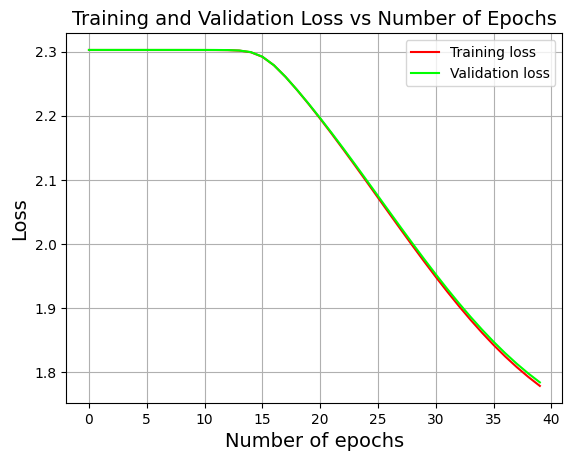

wandb: Agent Starting Run: lzgrpyvf with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_512_L2_0.5_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.3020235486696667 	Validation cost: 2.3020666705109534
Epoch number : 4
Training cost:  2.3005614866210924 	Validation cost: 2.3005110817544794
Epoch number : 6
Training cost:  2.299114492778706 	Validation cost: 2.298971476686389
Epoch number : 8
Training cost:  2.2976499602013365 	Validation cost: 2.2974130776995443
Epoch number : 10
Training cost:  2.296139327459197 	Validation cost: 2.295805320181569

Final training cost: 2.29535861652922


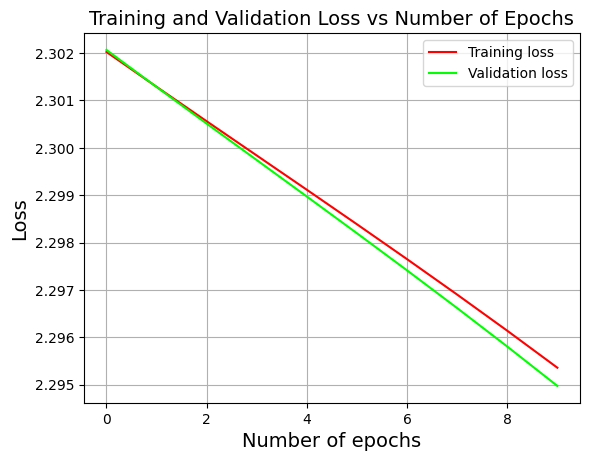

wandb: Agent Starting Run: 64ye4x9a with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_random_normal_op_momentum_bs_64_L2_0_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  2.3025760678853198 	Validation cost: 2.3025773926496966
Epoch number : 4
Training cost:  2.3025753562187603 	Validation cost: 2.3025793320307346
Epoch number : 6
Training cost:  2.3025746530316167 	Validation cost: 2.3025812352042143

Final training cost: 2.3025746530316167


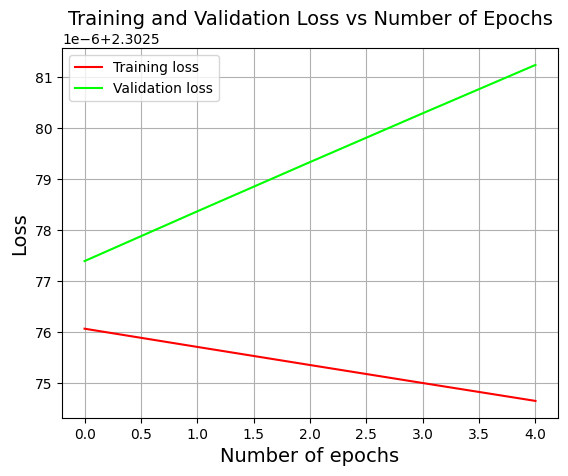

wandb: Agent Starting Run: 1lv7ui1s with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_128_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 4
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 6
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 8
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 10
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 12
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 14
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 16
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 18
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 20
Training cost:  2.256336146720815 	Validation cost: 2.258729900739444
Epoch number : 22
Training cost:  2.25633614672081

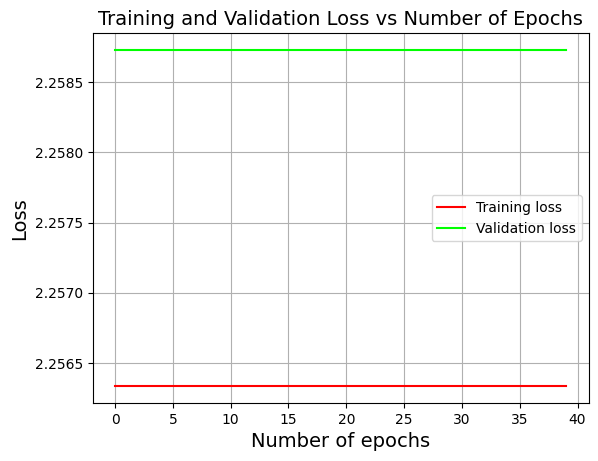

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9m1dwhlt with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_256_L2_0_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  2.302601245028734 	Validation cost: 2.302600106698679
Epoch number : 4
Training cost:  2.302601245028734 	Validation cost: 2.302600106698679
Epoch number : 6
Training cost:  2.302601245028734 	Validation cost: 2.302600106698679

Final training cost: 2.302601245028734


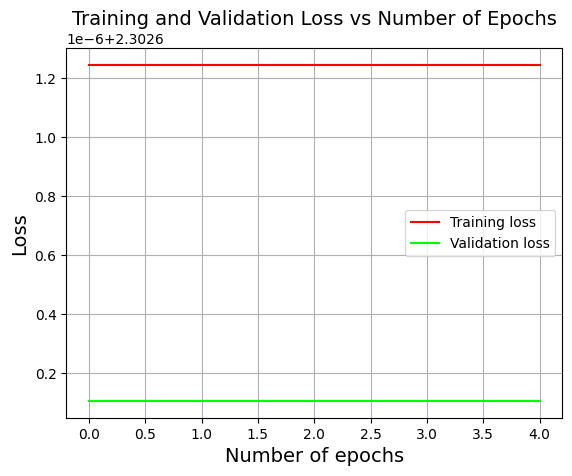

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7qm33cs with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_xavier_op_adam_bs_64_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  0.664464725522874 	Validation cost: 0.6808733171686049
Epoch number : 4
Training cost:  0.4894602596170408 	Validation cost: 0.5040559948800344
Epoch number : 6
Training cost:  0.45902200932113496 	Validation cost: 0.4756900292109963

Final training cost: 0.45902200932113496


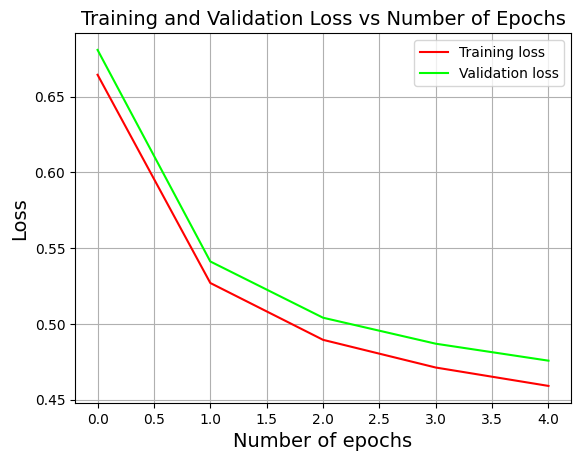

wandb: Agent Starting Run: 3uk8aajx with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_random_uniform_op_RMSprop_bs_32_L2_0.5_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.3025812994393404 	Validation cost: 2.302626926786705
Epoch number : 4
Training cost:  2.3025785546771345 	Validation cost: 2.3026804824414495
Epoch number : 6
Training cost:  2.3025779812134792 	Validation cost: 2.3027105506556023
Epoch number : 8
Training cost:  2.3025779413916965 	Validation cost: 2.3027271871142756
Epoch number : 10
Training cost:  2.3025780002967293 	Validation cost: 2.302736321205492
Epoch number : 12
Training cost:  2.302578055756719 	Validation cost: 2.3027413114564617
Epoch number : 14
Training cost:  2.3025780932038313 	Validation cost: 2.3027440364917338
Epoch number : 16
Training cost:  2.3025781154729486 	Validation cost: 2.3027455221737667
Epoch number : 18
Training cost:  2.302578127938433 	Validation cost: 2.3027463243908524
Epoch number : 20
Training cost:  2.302578135145448 	Validation cost: 2.3027467707791596
Epoch number : 22
Training cost:

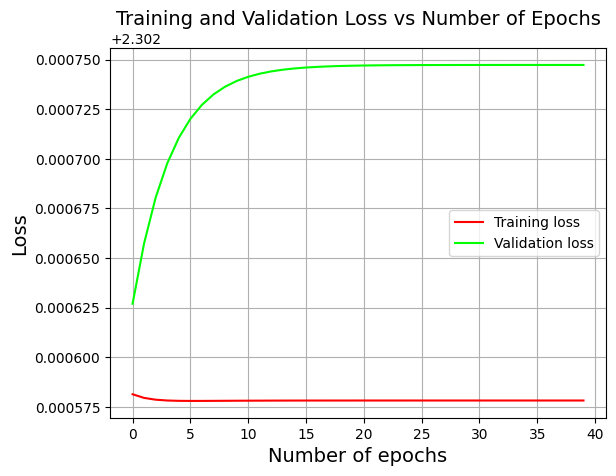

wandb: Agent Starting Run: l073blko with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_uniform_op_nadam_bs_64_L2_0.5_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  2.3100914145217804 	Validation cost: 2.30873287437336
Epoch number : 4
Training cost:  2.310466535604748 	Validation cost: 2.309519680852667
Epoch number : 6
Training cost:  2.3097829304952215 	Validation cost: 2.3089522956663457
Epoch number : 8
Training cost:  2.309082549792176 	Validation cost: 2.3083314815299985
Epoch number : 10
Training cost:  2.3084390562417987 	Validation cost: 2.3077415487657102
Epoch number : 12
Training cost:  2.3078452598900983 	Validation cost: 2.307179131316247
Epoch number : 14
Training cost:  2.3073029935797704 	Validation cost: 2.3066549220378736
Epoch number : 16
Training cost:  2.3068196876637055 	Validation cost: 2.30618255848724
Epoch number : 18
Training cost:  2.3063992688765937 	Validation cost: 2.305768456519532
Epoch number : 20
Training cost:  2.306038253150875 	Validation cost: 2.305410388967683

Final training cost: 2.3058775313861

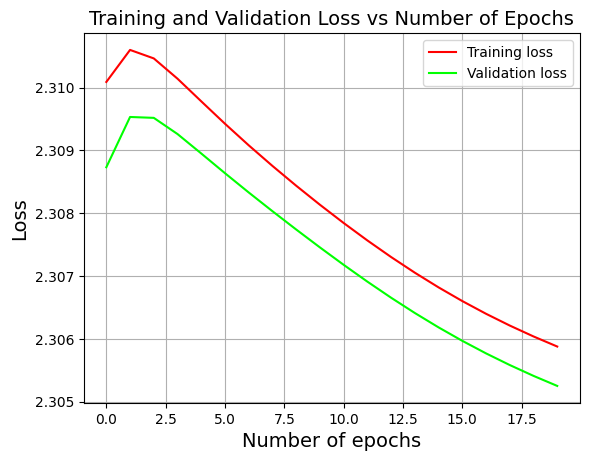

wandb: Agent Starting Run: d2rxktwz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_uniform_op_adam_bs_32_L2_0.5_ep_20_nn_64_nh_3
Epoch number : 2
Training cost:  0.8873461935917883 	Validation cost: 0.8982953250669472
Epoch number : 4
Training cost:  0.6911709495273515 	Validation cost: 0.6990521039102991
Epoch number : 6
Training cost:  0.691348415793001 	Validation cost: 0.6996596581444399
Epoch number : 8
Training cost:  0.7112382000994041 	Validation cost: 0.7159603721155543
Epoch number : 10
Training cost:  0.7148312517452994 	Validation cost: 0.7223363480209912
Epoch number : 12
Training cost:  0.7268168692590274 	Validation cost: 0.7337954120729739
Epoch number : 14
Training cost:  0.7345681545307463 	Validation cost: 0.7419933958610838
Epoch number : 16
Training cost:  0.7190699477497017 	Validation cost: 0.7283456655480443
Epoch number : 18
Training cost:  0.7076889163616102 	Validation cost: 0.7182169999076481
Epoch number : 20
Training cost:  0.7710205880692831 	Validation cost: 0.7815549435105829

Final training cost: 0.78559051

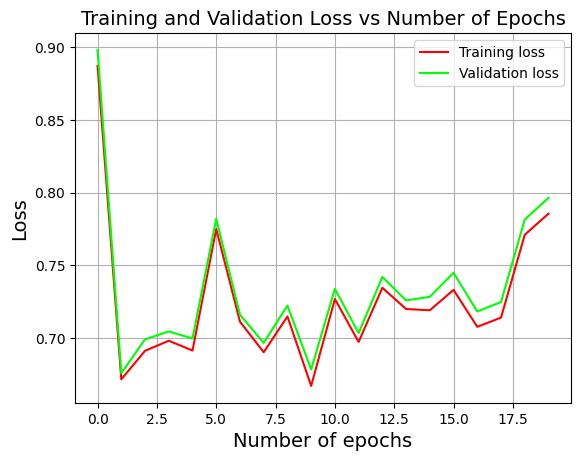

wandb: Agent Starting Run: utaqkhaj with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_xavier_op_adam_bs_64_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  2.313095019746809 	Validation cost: 2.3129249738369753
Epoch number : 4
Training cost:  2.3108090393580816 	Validation cost: 2.3098496999201013
Epoch number : 6
Training cost:  2.310046427796107 	Validation cost: 2.309186804710397
Epoch number : 8
Training cost:  2.3093141040302543 	Validation cost: 2.308539955114327
Epoch number : 10
Training cost:  2.308647291545287 	Validation cost: 2.3079349242439604

Final training cost: 2.3083346671740284


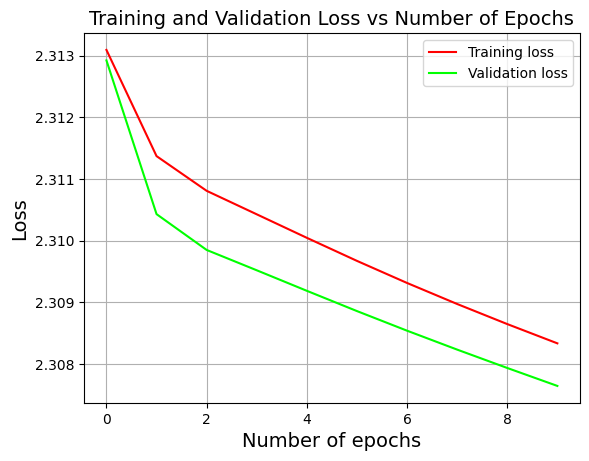

wandb: Agent Starting Run: pitecc8b with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_normal_op_RMSprop_bs_32_L2_0_ep_20_nn_32_nh_4
Epoch number : 2
Training cost:  1.1656583111720178 	Validation cost: 1.1719204436120185
Epoch number : 4
Training cost:  0.9672247844940495 	Validation cost: 0.973435142922512
Epoch number : 6
Training cost:  0.914982875814038 	Validation cost: 0.9215573973525986
Epoch number : 8
Training cost:  0.8755073038117244 	Validation cost: 0.8823094283282699
Epoch number : 10
Training cost:  0.8359506253123951 	Validation cost: 0.8431339237711292
Epoch number : 12
Training cost:  0.7987593660500659 	Validation cost: 0.8068335199233299
Epoch number : 14
Training cost:  0.7652513213876583 	Validation cost: 0.7749975945212133
Epoch number : 16
Training cost:  0.7395905011020729 	Validation cost: 0.750506170924449
Epoch number : 18
Training cost:  0.719251902854249 	Validation cost: 0.7307111226632822
Epoch number : 20
Training cost:  0.7033254767169639 	Validation cost: 0.7151827038007923

Final training cost: 0.6963006622

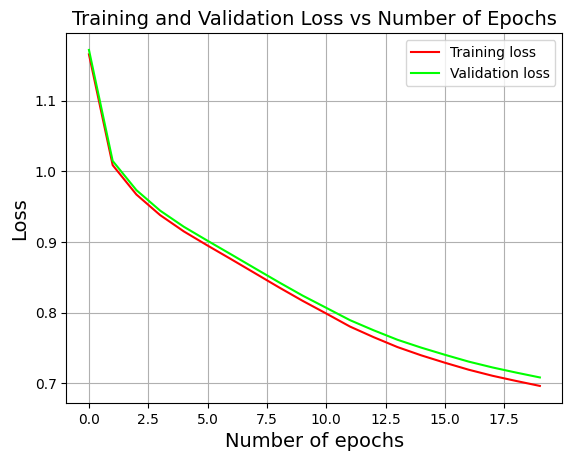

wandb: Agent Starting Run: pyj2rsng with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_uniform_op_sgd_bs_256_L2_0.0005_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  2.3011077383165466 	Validation cost: 2.3009432922338586
Epoch number : 4
Training cost:  2.299613391608104 	Validation cost: 2.2993511847854906
Epoch number : 6
Training cost:  2.2981789584337755 	Validation cost: 2.2978214151898726

Final training cost: 2.2981789584337755


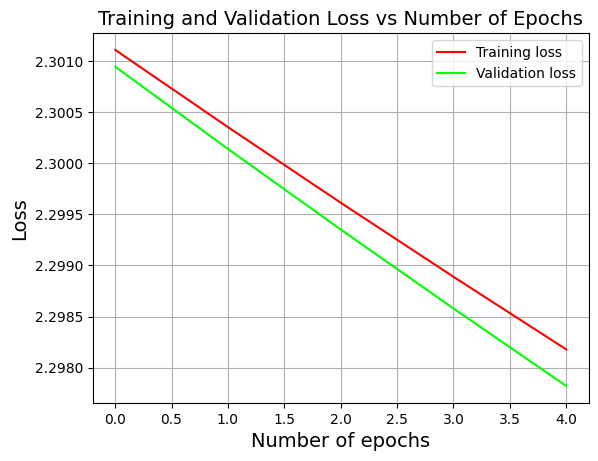

wandb: Agent Starting Run: 88gznrcw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_uniform_op_nadam_bs_32_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  1.783438278795805 	Validation cost: 1.792032781924021
Epoch number : 4
Training cost:  0.9585564445841309 	Validation cost: 0.9764729996022269
Epoch number : 6
Training cost:  0.4815662632672801 	Validation cost: 0.4871816723837742
Epoch number : 8
Training cost:  0.4223879862829891 	Validation cost: 0.44358562292148446
Epoch number : 10
Training cost:  0.3816176910011365 	Validation cost: 0.41817455208461507

Final training cost: 0.3886794407157141


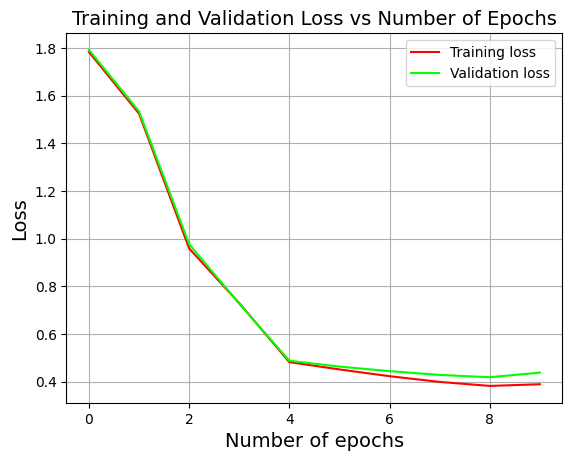

wandb: Agent Starting Run: yw4soyge with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_xavier_op_sgd_bs_32_L2_0.0005_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  2.2389631631010496 	Validation cost: 2.24413803401982
Epoch number : 4
Training cost:  2.082125242349021 	Validation cost: 2.086672096608122
Epoch number : 6
Training cost:  1.8587396848674858 	Validation cost: 1.864288661411717

Final training cost: 1.8587396848674858


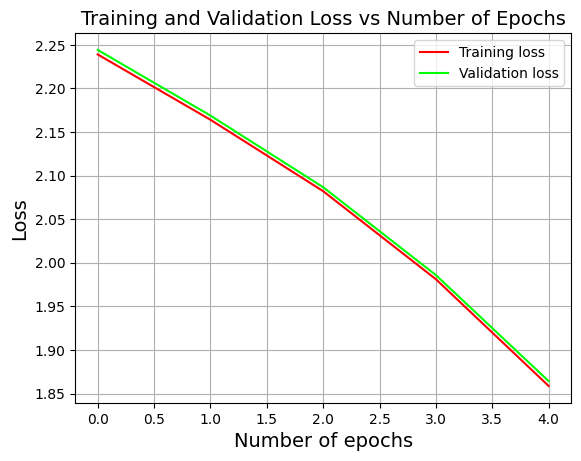

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2gaphjr with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_128_L2_0.0005_ep_20_nn_32_nh_4
Epoch number : 2
Training cost:  2.3025826500058684 	Validation cost: 2.302588673014828
Epoch number : 4
Training cost:  2.302580850013321 	Validation cost: 2.3025990617397465
Epoch number : 6
Training cost:  2.3025792238737086 	Validation cost: 2.302608635873851
Epoch number : 8
Training cost:  2.3025777443324733 	Validation cost: 2.302617447998229
Epoch number : 10
Training cost:  2.3025763883267834 	Validation cost: 2.302625548472032
Epoch number : 12
Training cost:  2.30257513633775 	Validation cost: 2.30263298529433
Epoch number : 14
Training cost:  2.3025739718422997 	Validation cost: 2.302639804025984
Epoch number : 16
Training cost:  2.302572880849476 	Validation cost: 2.3026460477592643
Epoch number : 18
Training cost:  2.302571851508208 	Validation cost: 2.302651757125005
Epoch number : 20
Training cost:  2.302570873775597 	Validation cost: 2.3026569703289064

Final training cost: 2.3025704015486057


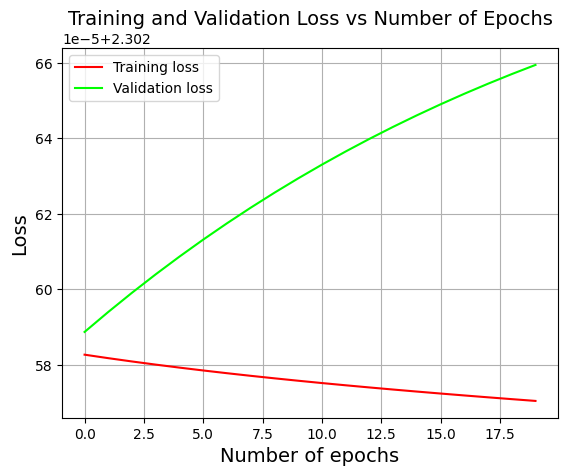

wandb: Agent Starting Run: a1233025 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_random_uniform_op_nadam_bs_16_L2_0.5_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  2.304888531354459 	Validation cost: 2.3056791379187107
Epoch number : 4
Training cost:  2.307490517740413 	Validation cost: 2.308286782765352
Epoch number : 6
Training cost:  2.308534356698409 	Validation cost: 2.309427177417984

Final training cost: 2.308534356698409


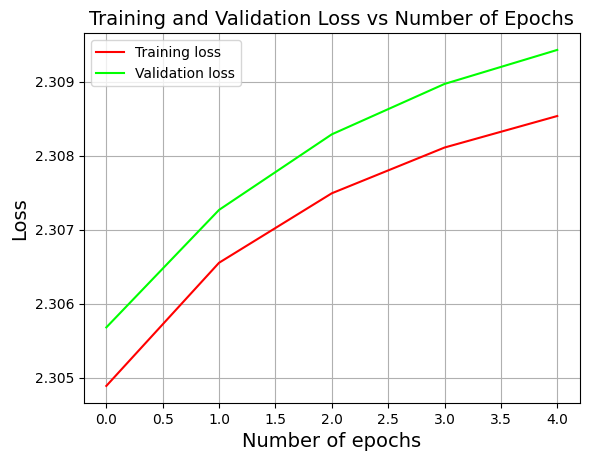

wandb: Agent Starting Run: tg12qkoz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_xavier_op_nadam_bs_32_L2_0.5_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  2.3029390940581864 	Validation cost: 2.3033632038595426
Epoch number : 4
Training cost:  2.30288228139571 	Validation cost: 2.3028288516252777
Epoch number : 6
Training cost:  2.3028416224440367 	Validation cost: 2.3028243795365344
Epoch number : 8
Training cost:  2.3028318757971036 	Validation cost: 2.3028636661826303
Epoch number : 10
Training cost:  2.3028305821999853 	Validation cost: 2.302888970696676
Epoch number : 12
Training cost:  2.3028304521124143 	Validation cost: 2.30289994284412
Epoch number : 14
Training cost:  2.3028303055560264 	Validation cost: 2.302904486423559
Epoch number : 16
Training cost:  2.3028300940255324 	Validation cost: 2.3029066345253257
Epoch number : 18
Training cost:  2.3028298600900885 	Validation cost: 2.3029079366708896
Epoch number : 20
Training cost:  2.302829626628513 	Validation cost: 2.302908949319282
Epoch number : 22
Training cost:  2.302829

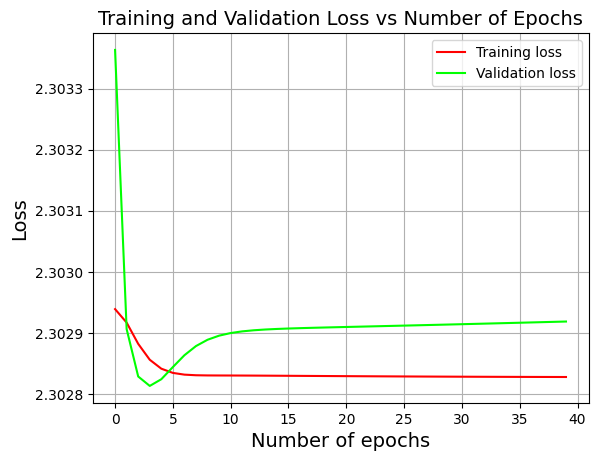

wandb: Agent Starting Run: xaj3l31m with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_normal_op_nestorov_bs_256_L2_0_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 4
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 6
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 8
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 10
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 12
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 14
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 16
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 18
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 20
Training cost:  2.302957247291427 	Validation cost: 2.303003907114115
Epoch number : 22
Training cost:  2.302957247

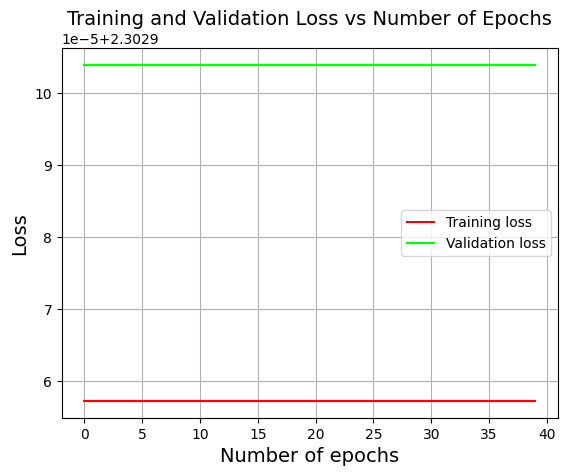

wandb: Agent Starting Run: x1ic0f9i with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_uniform_op_nadam_bs_32_L2_0.0005_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.3025507178512106 	Validation cost: 2.3025918452220284
Epoch number : 4
Training cost:  1.8175431799509691 	Validation cost: 1.7996886904381315
Epoch number : 6
Training cost:  1.5536866474056452 	Validation cost: 1.5417493219028473

Final training cost: 1.5536866474056452


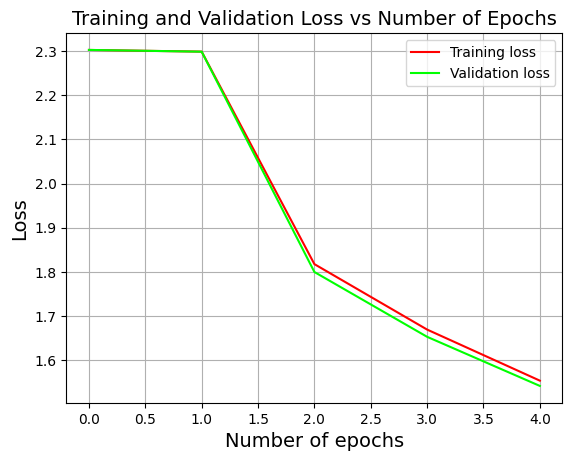

wandb: Agent Starting Run: ynryo5j3 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_uniform_op_nadam_bs_32_L2_0_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  2.3033844827357584 	Validation cost: 2.302885875349855
Epoch number : 4
Training cost:  2.3033914631983214 	Validation cost: 2.3028958411770013
Epoch number : 6
Training cost:  2.3033058944400544 	Validation cost: 2.302829565852411
Epoch number : 8
Training cost:  2.303219057271374 	Validation cost: 2.3027675744580276
Epoch number : 10
Training cost:  2.303135482294384 	Validation cost: 2.302713662772511
Epoch number : 12
Training cost:  2.3030566111172956 	Validation cost: 2.302668643758846
Epoch number : 14
Training cost:  2.3029830142092833 	Validation cost: 2.3026322715577816
Epoch number : 16
Training cost:  2.3029141811305167 	Validation cost: 2.302603169728941
Epoch number : 18
Training cost:  2.3028483303139446 	Validation cost: 2.302578880743932
Epoch number : 20
Training cost:  2.302782195023166 	Validation cost: 2.3025559710472336

Final training cost: 2.3027474774092

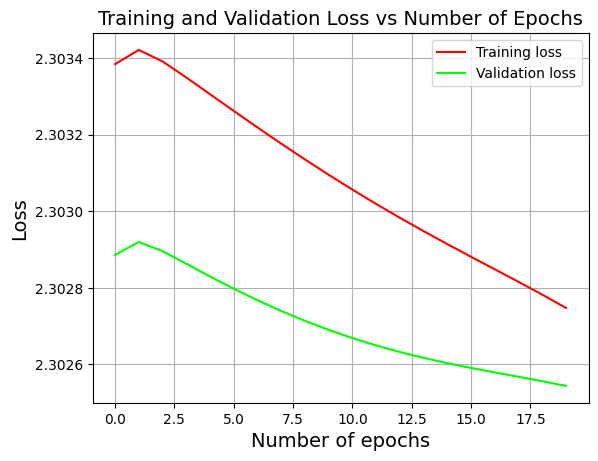

wandb: Agent Starting Run: jteoxrs0 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_random_uniform_op_nadam_bs_512_L2_0.5_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  2.302307746738882 	Validation cost: 2.302325137093748
Epoch number : 4
Training cost:  2.299433386060811 	Validation cost: 2.2992865100812607
Epoch number : 6
Training cost:  2.1331869545769675 	Validation cost: 2.1346889312852726

Final training cost: 2.1331869545769675


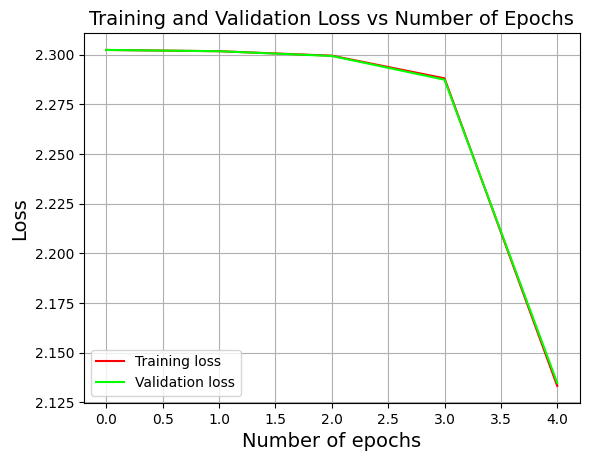

wandb: Agent Starting Run: tfx1ombd with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_128_L2_0_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  2.3825358983311857 	Validation cost: 2.385660494852729
Epoch number : 4
Training cost:  2.3825358983311857 	Validation cost: 2.385660494852729
Epoch number : 6
Training cost:  2.3825358983311857 	Validation cost: 2.385660494852729

Final training cost: 2.3825358983311857


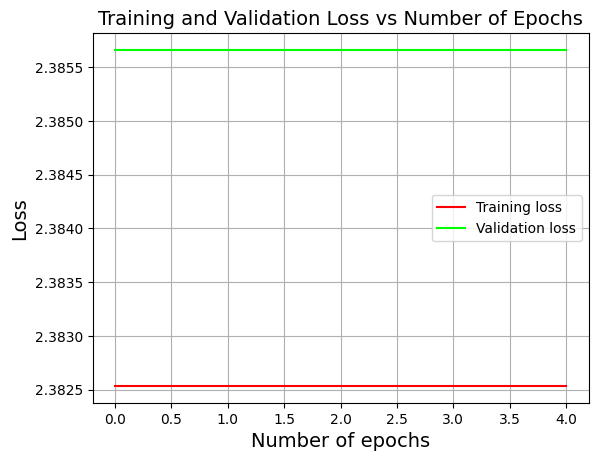

wandb: Agent Starting Run: d9kklnoa with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_sigmoid_in_xavier_op_momentum_bs_32_L2_0_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  2.3021312155085885 	Validation cost: 2.3019871015226228
Epoch number : 4
Training cost:  2.3018348476716546 	Validation cost: 2.3016786917901864
Epoch number : 6
Training cost:  2.3015258020714153 	Validation cost: 2.3013725181320543
Epoch number : 8
Training cost:  2.301211161831832 	Validation cost: 2.3010608249567945
Epoch number : 10
Training cost:  2.3008889140747626 	Validation cost: 2.300741616724438

Final training cost: 2.300724275168655


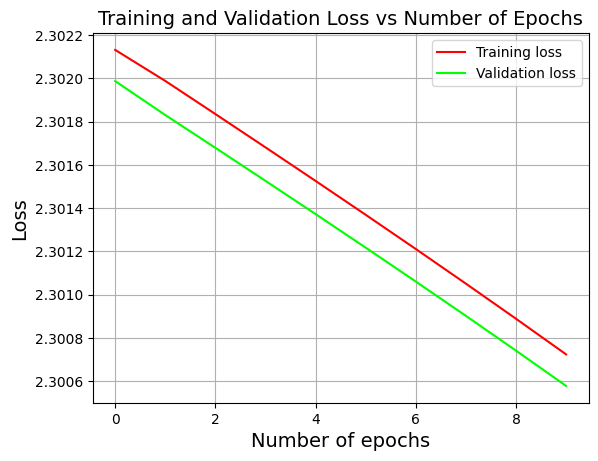

wandb: Agent Starting Run: rrkv7yty with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_256_L2_0_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302584775814175 	Validation cost: 2.3025847492897817
Epoch number : 4
Training cost:  2.302584775814175 	Validation cost: 2.3025847492897817
Epoch number : 6
Training cost:  2.302584775814175 	Validation cost: 2.3025847492897817

Final training cost: 2.302584775814175


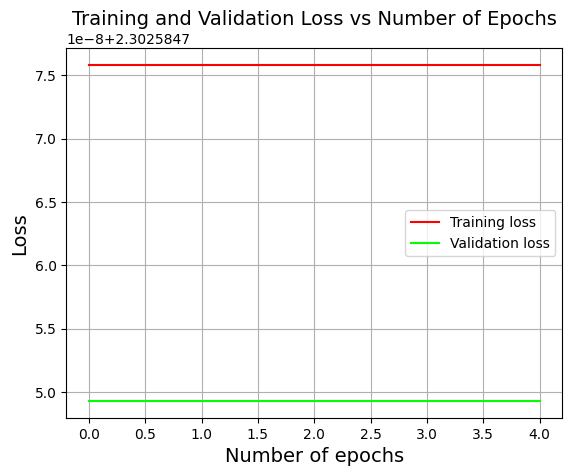

wandb: Agent Starting Run: g59mao9l with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_random_uniform_op_adam_bs_16_L2_0_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.306432189379456 	Validation cost: 2.3071149817229615
Epoch number : 4
Training cost:  2.3046369492275125 	Validation cost: 2.305089731989517
Epoch number : 6
Training cost:  2.3037398368115714 	Validation cost: 2.304058472189721
Epoch number : 8
Training cost:  2.303464744468646 	Validation cost: 2.303729024891623
Epoch number : 10
Training cost:  2.303409916485044 	Validation cost: 2.3036549235742396
Epoch number : 12
Training cost:  2.3034805393204967 	Validation cost: 2.303727100457921
Epoch number : 14
Training cost:  2.303673543749068 	Validation cost: 2.3039423917098043
Epoch number : 16
Training cost:  2.3040321305207327 	Validation cost: 2.3043495114367465
Epoch number : 18
Training cost:  2.3046305338835142 	Validation cost: 2.305027764688061
Epoch number : 20
Training cost:  2.305528212136904 	Validation cost: 2.3060317900483245

Final training cost: 2.306081109447146

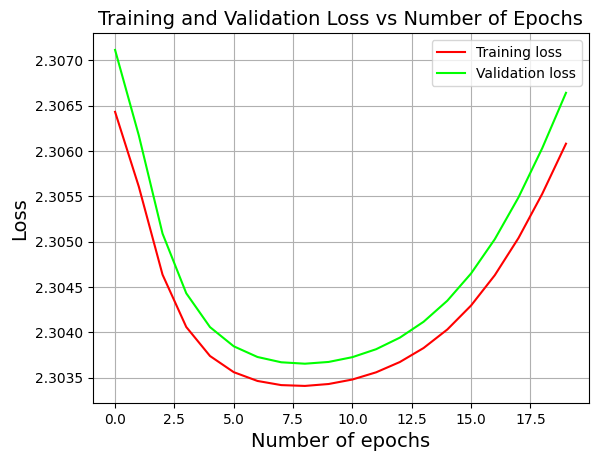

wandb: Agent Starting Run: 44ymii22 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_xavier_op_sgd_bs_16_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.8183638820891332 	Validation cost: 0.8315925850998127
Epoch number : 4
Training cost:  0.5651039271852794 	Validation cost: 0.5785435075760341
Epoch number : 6
Training cost:  0.4979432778570875 	Validation cost: 0.5110862215061894
Epoch number : 8
Training cost:  0.4633544805120498 	Validation cost: 0.4766037076667399
Epoch number : 10
Training cost:  0.44084655891132035 	Validation cost: 0.45454881852327733

Final training cost: 0.43186455578226596


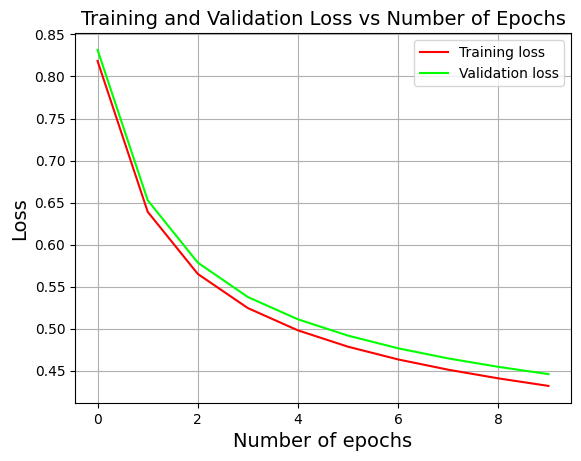

wandb: Agent Starting Run: 2j0wfobx with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_xavier_op_nadam_bs_512_L2_0_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  1.855747532013883 	Validation cost: 1.8612047886858964
Epoch number : 4
Training cost:  0.7562753212009033 	Validation cost: 0.7709660126243068
Epoch number : 6
Training cost:  0.6083639565271337 	Validation cost: 0.6210525807163865
Epoch number : 8
Training cost:  0.5392728028878294 	Validation cost: 0.5503656666304738
Epoch number : 10
Training cost:  0.5071945581163472 	Validation cost: 0.5171524165461909
Epoch number : 12
Training cost:  0.4849055045404805 	Validation cost: 0.49409142943414597
Epoch number : 14
Training cost:  0.46705406228371305 	Validation cost: 0.4757617718878256
Epoch number : 16
Training cost:  0.44768452296015876 	Validation cost: 0.4565179009293053
Epoch number : 18
Training cost:  0.42969770511958616 	Validation cost: 0.43908143289352247
Epoch number : 20
Training cost:  0.4157905754280042 	Validation cost: 0.42703519679280977

Final training cost: 0.414140547

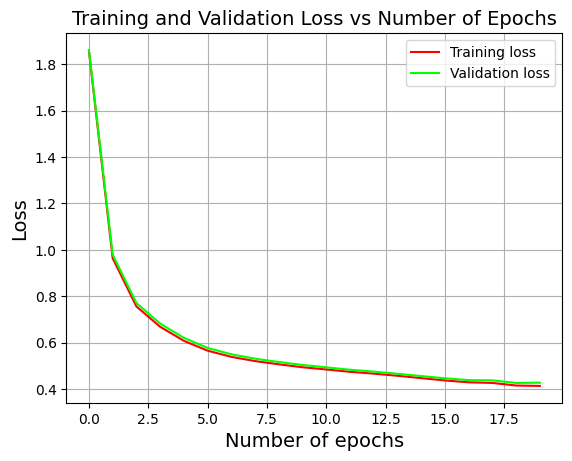

wandb: Agent Starting Run: oqyuyl9l with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_uniform_op_nadam_bs_512_L2_0.0005_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.302511710995846 	Validation cost: 2.3025149108250424
Epoch number : 4
Training cost:  2.302270324044195 	Validation cost: 2.3022892601254683
Epoch number : 6
Training cost:  2.300288207575869 	Validation cost: 2.3002238479063757

Final training cost: 2.300288207575869


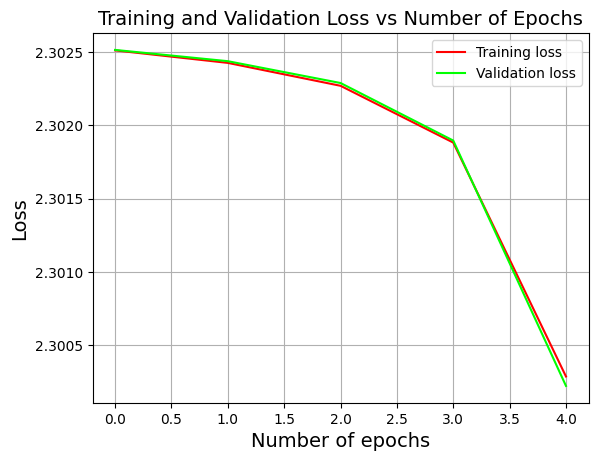

wandb: Agent Starting Run: zy3ov3lk with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_16_L2_0.5_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  2.3681230139023377 	Validation cost: 2.3821882106811443
Epoch number : 4
Training cost:  2.307991468278257 	Validation cost: 2.318720902670008
Epoch number : 6
Training cost:  2.301949866364773 	Validation cost: 2.311430014369434

Final training cost: 2.301949866364773


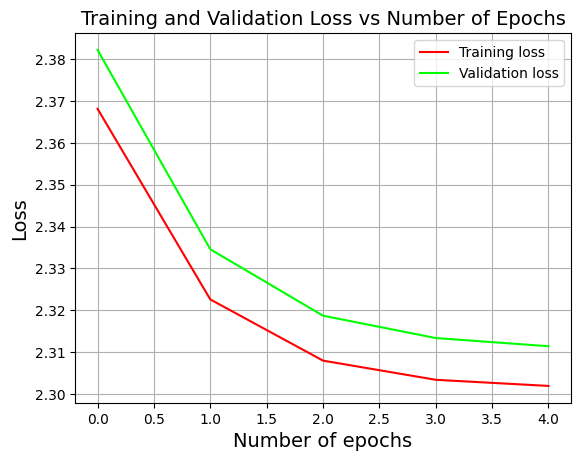

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hlnkwu7k with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_16_L2_0.0005_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  2.302609093867841 	Validation cost: 2.3027387092928366
Epoch number : 4
Training cost:  2.3029218504536693 	Validation cost: 2.303375370675094
Epoch number : 6
Training cost:  2.303557459690121 	Validation cost: 2.3043172811008534
Epoch number : 8
Training cost:  2.3044418062259022 	Validation cost: 2.3054875289170655
Epoch number : 10
Training cost:  2.305482861316365 	Validation cost: 2.3067913426531494
Epoch number : 12
Training cost:  2.306574087224143 	Validation cost: 2.3081181761936125
Epoch number : 14
Training cost:  2.3076184033459386 	Validation cost: 2.309365113759678
Epoch number : 16
Training cost:  2.3085574603916785 	Validation cost: 2.310467534827267
Epoch number : 18
Training cost:  2.3093737866530937 	Validation cost: 2.3114057159807087
Epoch number : 20
Training cost:  2.31007477428662 	Validation cost: 2.312191634759813
Epoch number : 22
Training cost:  2.3

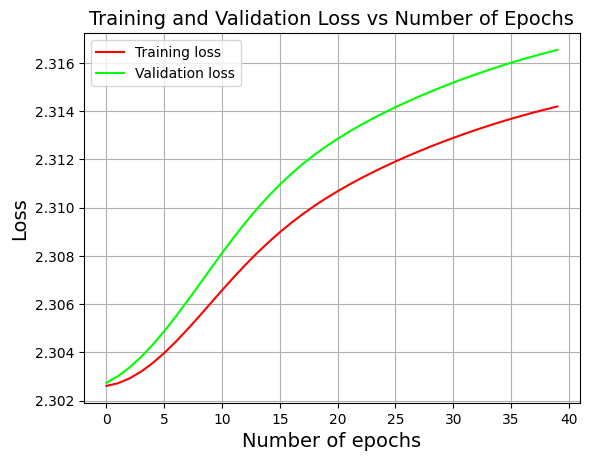

wandb: Agent Starting Run: onhcrxp7 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_xavier_op_nadam_bs_16_L2_0.5_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  0.6958414213272515 	Validation cost: 0.7036420232778247
Epoch number : 4
Training cost:  0.6308404744845385 	Validation cost: 0.6386139452894793
Epoch number : 6
Training cost:  0.624026007833188 	Validation cost: 0.6328933101563669
Epoch number : 8
Training cost:  0.626905596206991 	Validation cost: 0.6355183441807117
Epoch number : 10
Training cost:  0.6290568735014436 	Validation cost: 0.6374715291032221
Epoch number : 12
Training cost:  0.6274972350939181 	Validation cost: 0.6357473126328367
Epoch number : 14
Training cost:  0.6279496097892149 	Validation cost: 0.6359398416917124
Epoch number : 16
Training cost:  0.6284984516321275 	Validation cost: 0.6369406769701415
Epoch number : 18
Training cost:  0.629577327943942 	Validation cost: 0.6376595784203688
Epoch number : 20
Training cost:  0.6316950609123065 	Validation cost: 0.6391043602969697
Epoch number : 22
Training cost:  0.6321

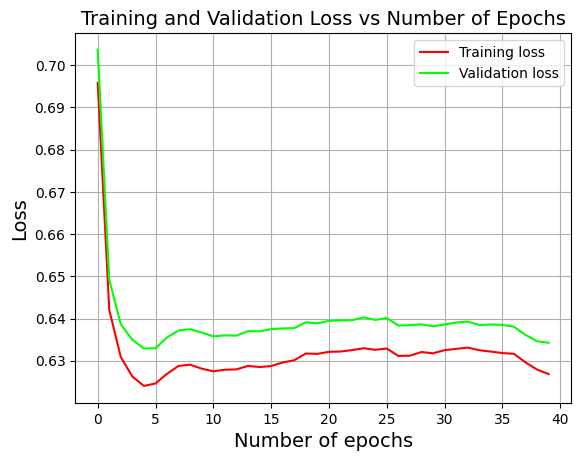

wandb: Agent Starting Run: h2p1q7e1 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_16_L2_0_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  2.3025507718167604 	Validation cost: 2.3025118414929127
Epoch number : 4
Training cost:  2.3025507718167604 	Validation cost: 2.3025118414929127
Epoch number : 6
Training cost:  2.3025507718167604 	Validation cost: 2.3025118414929127

Final training cost: 2.3025507718167604


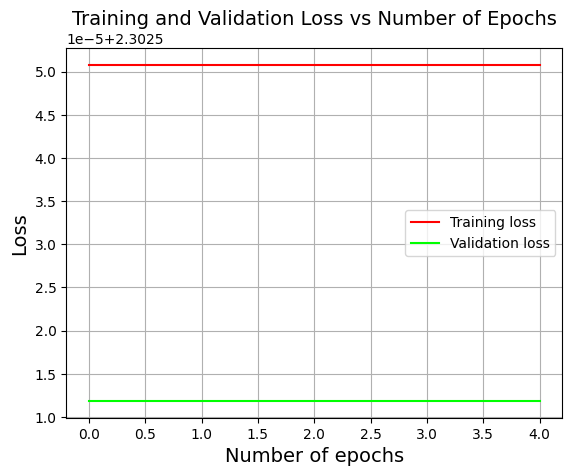

wandb: Agent Starting Run: oyfwg073 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_xavier_op_sgd_bs_32_L2_0.5_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  2.304603751977253 	Validation cost: 2.3188243145615854
Epoch number : 4
Training cost:  2.3041295536544686 	Validation cost: 2.316591795499077
Epoch number : 6
Training cost:  2.303976099402708 	Validation cost: 2.3151908627680817

Final training cost: 2.303976099402708


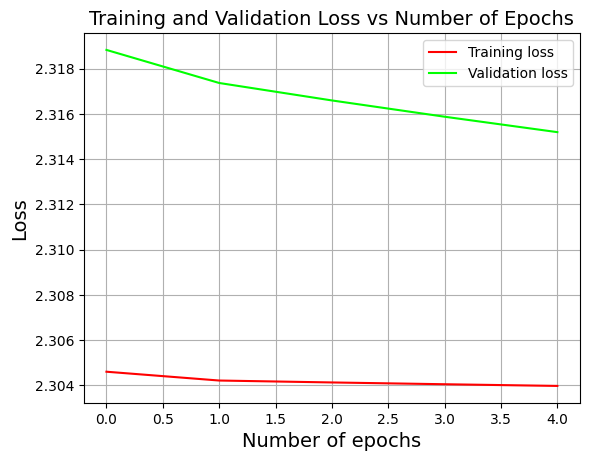

wandb: Agent Starting Run: 8f1jot6r with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_random_uniform_op_RMSprop_bs_32_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  1.6691384613707756 	Validation cost: 1.675013574382981
Epoch number : 4
Training cost:  1.0539086534986362 	Validation cost: 1.0577926062906189
Epoch number : 6
Training cost:  0.7779285007597897 	Validation cost: 0.7914328181890291
Epoch number : 8
Training cost:  0.6650446932538376 	Validation cost: 0.6716348999973254
Epoch number : 10
Training cost:  0.6375576102646976 	Validation cost: 0.6447089919721182
Epoch number : 12
Training cost:  0.6277494909904386 	Validation cost: 0.635337771549575
Epoch number : 14
Training cost:  0.6210504319710034 	Validation cost: 0.6289665829455596
Epoch number : 16
Training cost:  0.6155369124189459 	Validation cost: 0.6237272389485041
Epoch number : 18
Training cost:  0.6108532011045218 	Validation cost: 0.6193020981942126
Epoch number : 20
Training cost:  0.6064012170105202 	Validation cost: 0.6151095793699152
Epoch number : 22
Training c

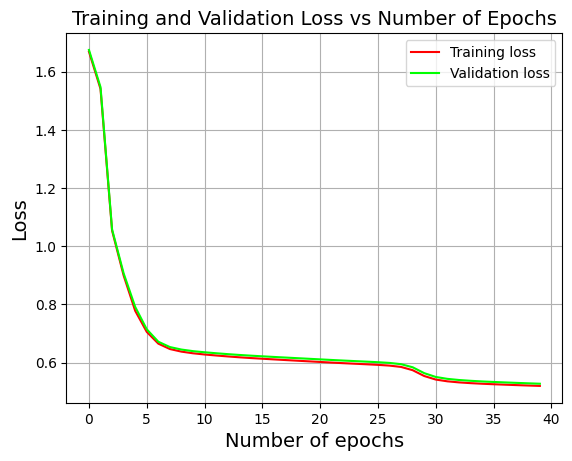

wandb: Agent Starting Run: k9dtkce8 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_xavier_op_nadam_bs_512_L2_0.5_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  2.0460135429076876 	Validation cost: 2.0596133440196205
Epoch number : 4
Training cost:  1.0070700140124833 	Validation cost: 1.0287859612906303
Epoch number : 6
Training cost:  0.7956129109219809 	Validation cost: 0.8182609520843116

Final training cost: 0.7956129109219809


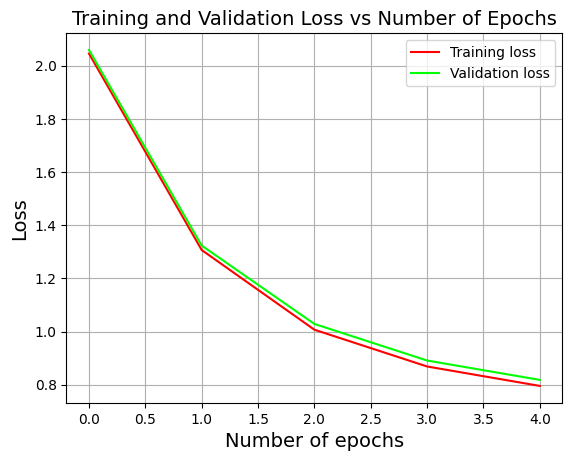

wandb: Agent Starting Run: klb0202y with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_random_uniform_op_RMSprop_bs_512_L2_0.0005_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  2.2569546103258777 	Validation cost: 2.2569256241527063
Epoch number : 4
Training cost:  1.8708683966302584 	Validation cost: 1.8738715802276906
Epoch number : 6
Training cost:  1.7235908174079249 	Validation cost: 1.7271941690469548
Epoch number : 8
Training cost:  1.6898278984874984 	Validation cost: 1.694947786153946
Epoch number : 10
Training cost:  1.6773443720987002 	Validation cost: 1.6837138631132154
Epoch number : 12
Training cost:  1.6677157265952558 	Validation cost: 1.6733356401121242
Epoch number : 14
Training cost:  1.6578796779006981 	Validation cost: 1.6636495493476284
Epoch number : 16
Training cost:  1.6438692255115417 	Validation cost: 1.6497990253548513
Epoch number : 18
Training cost:  1.6097760712905689 	Validation cost: 1.6168867925863888
Epoch number : 20
Training cost:  1.5412364104835983 	Validation cost: 1.5505804102439829

Final training cost: 1.

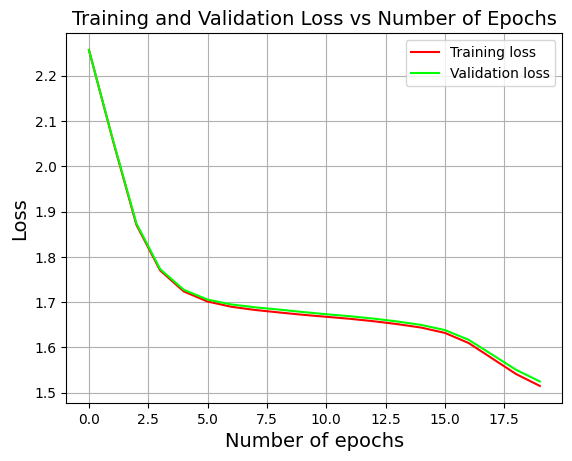

wandb: Agent Starting Run: 1dkkcbom with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_xavier_op_adam_bs_16_L2_0_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  0.46580116325222404 	Validation cost: 0.48270602301234794
Epoch number : 4
Training cost:  0.4774728876243998 	Validation cost: 0.5128739213955956
Epoch number : 6
Training cost:  0.5587119668484637 	Validation cost: 0.6168996340506512

Final training cost: 0.5587119668484637


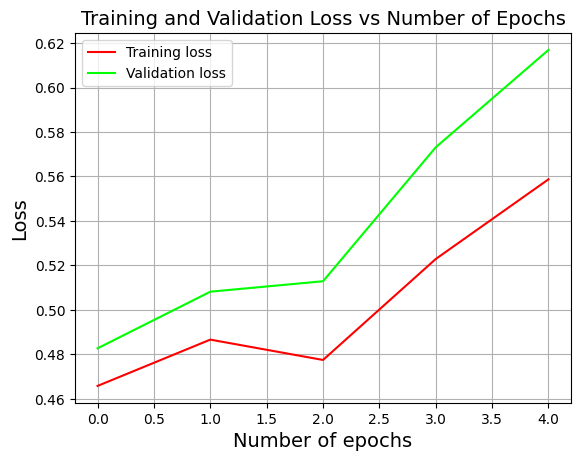

wandb: Agent Starting Run: n63hz9bo with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_normal_op_nestorov_bs_256_L2_0.5_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  2.302662713963252 	Validation cost: 2.3032814278332014
Epoch number : 4
Training cost:  2.302662713963252 	Validation cost: 2.3032814278332014
Epoch number : 6
Training cost:  2.302662713963252 	Validation cost: 2.3032814278332014
Epoch number : 8
Training cost:  2.302662713963252 	Validation cost: 2.3032814278332014
Epoch number : 10
Training cost:  2.302662713963252 	Validation cost: 2.3032814278332014

Final training cost: 2.302662713963252


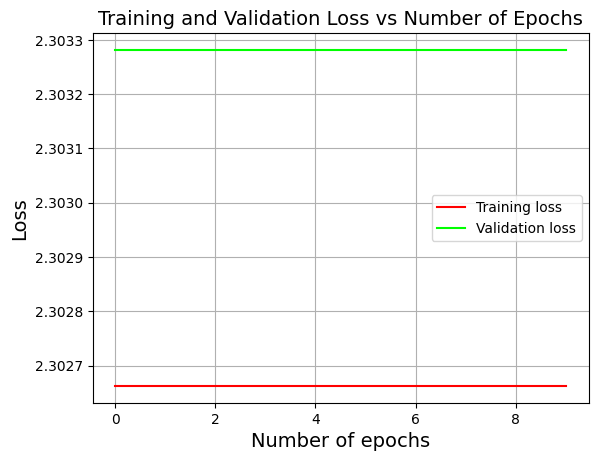

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9pp86ujs with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_xavier_op_sgd_bs_64_L2_0_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  1.2605299369162506 	Validation cost: 1.273075534525197
Epoch number : 4
Training cost:  0.8313940958248104 	Validation cost: 0.8429081314227727
Epoch number : 6
Training cost:  0.7026028461038785 	Validation cost: 0.7124053798277103
Epoch number : 8
Training cost:  0.635004040991781 	Validation cost: 0.6436222841320621
Epoch number : 10
Training cost:  0.5918876060125713 	Validation cost: 0.5996049999479459
Epoch number : 12
Training cost:  0.5614776161073186 	Validation cost: 0.5684996249288778
Epoch number : 14
Training cost:  0.5386735151477083 	Validation cost: 0.5451752734074649
Epoch number : 16
Training cost:  0.5208180314754619 	Validation cost: 0.5269348232961962
Epoch number : 18
Training cost:  0.506351724093793 	Validation cost: 0.5121783919367425
Epoch number : 20
Training cost:  0.49429579028199233 	Validation cost: 0.4998975469097893
Epoch number : 22
Training cost:  0.4840116

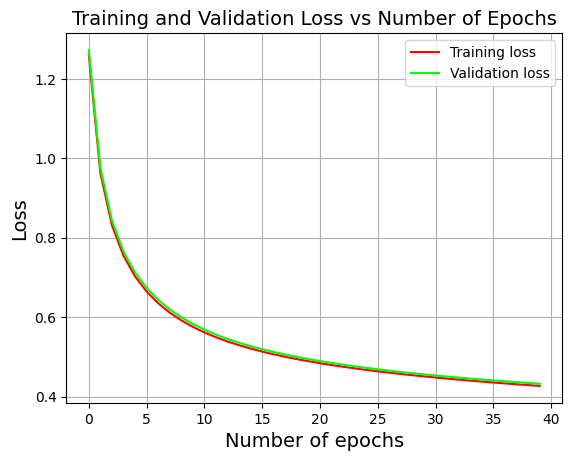

wandb: Agent Starting Run: oe0uvajq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_relu_in_random_normal_op_nestorov_bs_64_L2_0.5_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 4
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 6
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 8
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 10
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 12
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 14
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 16
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 18
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733
Epoch number : 20
Training cost:  2.3025987031538038 	Validation cost: 2.3027075818156733

Final training cost: 2.302

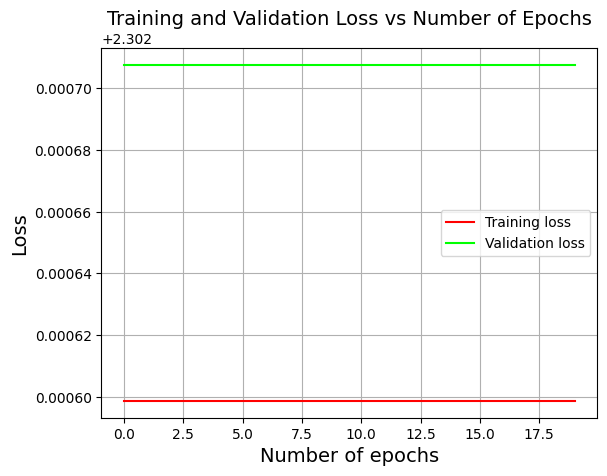

wandb: Agent Starting Run: 2wukqckr with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_512_L2_0.0005_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 4
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 6
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 8
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 10
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 12
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 14
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 16
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 18
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746
Epoch number : 20
Training cost:  2.3026130679129326 	Validation cost: 2.3026153717628746

Final training cost: 

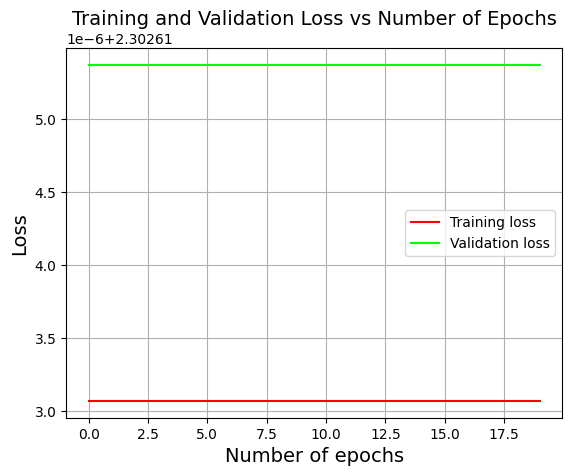

wandb: Agent Starting Run: py5eyx0x with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_uniform_op_nadam_bs_64_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.3037304949853263 	Validation cost: 2.303113630894188


In [ ]:
sweep_config = {
  "name": "CS6910 Assignment 1 - Cross Entropy Loss",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["sigmoid", "relu", "tanh"]
        },
        "init_mode": {
            "values": ["xavier", "random_uniform", "random_normal"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nestorov", "adam", "nadam", "RMSprop"]
        },
        "batch_size": {
            "values": [16,32,64,128,256,512]
        },
        "epochs": {
            "values": [5, 10, 20, 40]
        },
        "L2_lamb": {
            "values": [0, 0.0005, 0.5]
        },
        "num_neurons": {
            "values": [32, 64, 128]
        },
        "num_hidden": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DA6401-Assignment1")
wandb.agent(sweep_id, NN_fit, count=120)

# Training the model with the best combination of hyperparameters

#### Setting Hyperparameters based on wandb results

These are the best choices for hyperparameters chosen using wandb.ai's sweep feature

In [ ]:
LEARNING_RATE = 0.001
ACTIVATION = "relu"
INITIALIZER = "xavier"
OPTIMIZER = "RMSprop"
BATCH_SIZE = 512
EPOCHS = 40
L2_lambda = 0.0005
NUM_NEURONS = 128
NUM_HIDDEN = 3

LOSS = 'categorical_crossentropy'

#### Training on the full dataset

In [ ]:
def NN_best_fit(X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                num_neurons = 64, num_hidden = 3):
    """This function is used to train the neural network on the full dataset given the best set of hyperparameter values

    X_train: numpy array
        train dataset

    y_train_one_hot: numpy array
        train labels with one-hot encoding

    learning_rate: float

    activation_f: string
        activation functions for all the layers except the last layer which is softmax

    init_mode: string
        initialization mode
    
    optimizer: string
        optimization routine

    bach_size: int
        minibatch size

    loss: string
        loss function

    epochs: int
        number of epochs to be used

    L2_lamb: float
        lambda for L2 regularisation of weights

    num_neurons: int
        number of neurons in every hidden layer

    num_hidden: 
        number of hidden layers

    Returns
    -------

    parameters: dict
        weights and biases of the NN model

    epoch_cost: list
        training costs with every epoch
    

    """
    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            # Nesterov
            if optimizer == 'nesterov':
                L = len(params)//2
                # look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                # call momentum
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            # Nadam optimizer
            elif optimizer=='nadam':
                L = len(params)//2

                # Look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                # call Adam
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            # # custom optimizer
            # elif optimizer == 'insert your nesterov accelerated optimiser here':
            #     #insert your optimiser here if it has Nesterov accelerated gradients logic

            #     #insert lookahead logic here

            #     #for weight updates, call that optimiser's weight update code here
            #     pass

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

                # # custom optimizer
                # elif optimizer == 'insert your optimiser here':
                #     # Insert your optimiser update routine here only if it does not have nesterov accelerated gradients logic
                #     pass
                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)

        epoch_cost.append(cost)

    
    # Plot the training cost curve
    plt.plot(list(range(len(epoch_cost))), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()


    return params, epoch_cost

Epoch number:  2 	Training cost: 0.6157483964698321
Epoch number:  4 	Training cost: 0.43130607603682775
Epoch number:  6 	Training cost: 0.38159118108017887
Epoch number:  8 	Training cost: 0.34199573129469835
Epoch number:  10 	Training cost: 0.3181263586475795
Epoch number:  12 	Training cost: 0.2917333873577151
Epoch number:  14 	Training cost: 0.2880727567675014
Epoch number:  16 	Training cost: 0.276130576208186
Epoch number:  18 	Training cost: 0.2666996323444209
Epoch number:  20 	Training cost: 0.2539770544016791
Epoch number:  22 	Training cost: 0.2589126464434364
Epoch number:  24 	Training cost: 0.2351724568007873
Epoch number:  26 	Training cost: 0.21234576754515902
Epoch number:  28 	Training cost: 0.1984086509773893
Epoch number:  30 	Training cost: 0.22952559868599032
Epoch number:  32 	Training cost: 0.18713138759344058
Epoch number:  34 	Training cost: 0.16998011681751268
Epoch number:  36 	Training cost: 0.18016228434216805
Epoch number:  38 	Training cost: 0.2158057

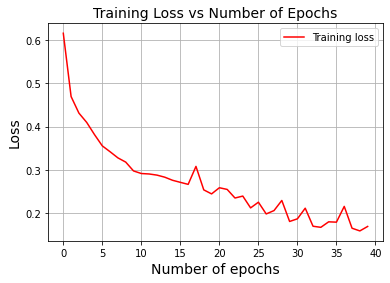

In [ ]:
# One hot encoding for class labels (full training data)
y_one_hot = np.zeros((10, M + Mval))
y_one_hot[y, np.array(list(range(M+Mval)))] = 1


learned_parameters, epoch_cost = NN_best_fit(X, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

#### Model Evaluation with X_test dataset

In [ ]:
train_predictions, test_predictions = NN_evaluate(X, y, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 94.055 %
Test accuracy = 88.48 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.87      0.69      0.77      1000
           3       0.87      0.92      0.89      1000
           4       0.79      0.83      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.70      0.69      0.70      1000
           7       0.96      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



#### Confusion Matrix (Training set)

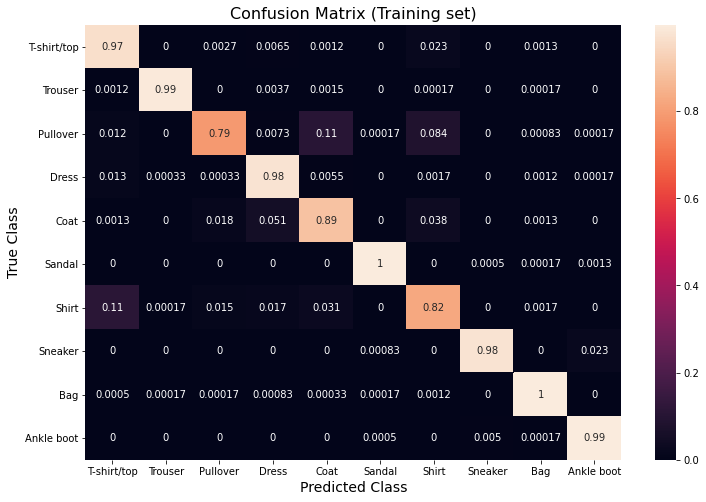

In [ ]:
bern_cnf_matrix_train = confusion_matrix(y, train_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Training set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("trainmatrix")
plt.show()

#### Confusion Matrix (Test set)

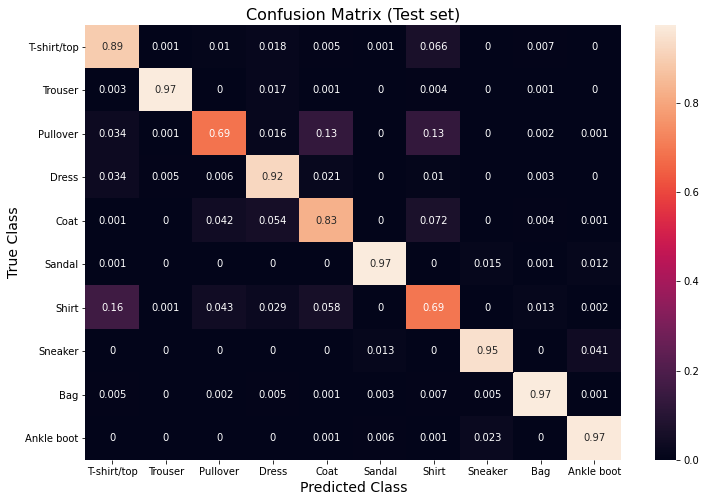

In [ ]:
bern_cnf_matrix_test = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_test, annot=bern_cnf_matrix_test,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("testmatrix")
plt.show()